In [ ]:
#@title Install dependencies and setup SplineCAM

!pip install --upgrade gdown
!git clone https://github.com/AhmedImtiazPrio/splinecam.git

!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25

!echo "deb http://cz.archive.ubuntu.com/ubuntu bionic main universe" >> /etc/apt/sources.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install networkx
!pip install python-igraph>=0.10
!pip install tqdm
!pip install livelossplot

!pip uninstall torch torchvision -y
!pip install --pre torch==1.12+cu116 torchvision -f https://download.pytorch.org/whl/torch_stable.html

!mkdir animation
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Cloning into 'splinecam'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 1), reused 21 (delta 1), pack-reused 0
Unpacking objects: 100% (25/25), 41.72 KiB | 562.00 KiB/s, done.
Executing: /tmp/apt-key-gpghome.ZMRHvXq1Oa/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.te

In [ ]:
#@title Hepler Functions and Imports

import sys
sys.path.append('./splinecam')

import splinecam as splinecam
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch

import time
from livelossplot import PlotLosses
import copy
import tqdm

def make_dataloader(generator,n,
                 noise=0.05,seed=0,
                 batch_size=128):
    
    X,y = generator(n_samples=n,
                        shuffle=False,
                        noise=noise,
                        random_state=seed)
    
    inputs = torch.hstack([
        torch.Tensor(X),torch.Tensor(y[...,None])
    ])
    
    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader

@torch.no_grad()
def get_hyp_endpoints(poly,hyps,verify=True):
    
    q = splinecam.graph.get_intersection_pattern(poly,hyps)
    hyp_v1_v2_idx = splinecam.graph.edge_hyp_intersections(q.T,poly,hyps)
    poly_lines = splinecam.graph.make_line_2D(poly[hyp_v1_v2_idx[:,1]],poly[hyp_v1_v2_idx[:,2]])

    poly_int_hyps = hyps[hyp_v1_v2_idx[:,0]]
    v,flag = splinecam.graph.find_intersection_2D(poly_lines,
                                  poly_int_hyps,
                                  verify=verify)

    v = v.type(poly_lines.type())

    if verify:

        assert flag

        flag = splinecam.graph.verify_collinear(v,
                                poly[hyp_v1_v2_idx[:,1]],
                                poly[hyp_v1_v2_idx[:,2]]
                                )

        assert flag

    hyp_endpoints = v.reshape(-1,2,v.shape[-1])
    return hyp_endpoints


@torch.no_grad()
def to_next_layer_partition_batched(cycles, Abw, current_layer, NN,
                                    dtype=torch.float64, device='cuda',
                                    batch_size=-1, fwd_batch_size=-1):
    
    if batch_size == -1: ## revert to non-batched
        res_regions, new_cyc_idx = splinecam.graph.to_next_layer_partition(
            cycles, Abw, current_layer, NN, dtype, device
        )
        return res_regions, new_cyc_idx
    
    vec_cyc,cyc_idx,ends = splinecam.graph.cycles_list2vec(cycles)
    
#     cycles_next = NN.layers[:current_layer].forward(vec_cyc[:128].to(device))
#     q = NN.layers[current_layer].get_intersection_pattern(cycles_next)
    
#     print(q.shape)
    
    fused_op = lambda x: NN.layers[current_layer].get_intersection_pattern(
        NN.layers[:current_layer].forward(x))
    
        
    q = splinecam.graph._batched_gpu_op(fused_op, 
                        vec_cyc,
                        workers = 2,
                        out_size=(
                            vec_cyc.shape[0],
                            torch.prod(NN.layers[current_layer].output_shape),
                        ),
                        batch_size = fwd_batch_size, out_device='cpu')                                  
    
    
    n_hyps  = torch.prod(NN.layers[current_layer].output_shape)
    
    ## edge intersections. remove between cycles
    mask = q.T[...,:-1] != q.T[...,1:]
    mask = mask.cpu()
    mask[:,(ends-1)[:-1]] = False
    
    if mask.sum() == 0:
        print('no intersections')
        return 
    
#     del  q
#     del cycles_next
    
    ## get indices for hyps-vertex-cycle triads
    hyp_vert_idx = torch.vstack(torch.where(mask)).T
    hyp_vert_cyc_idx = torch.hstack([hyp_vert_idx,cyc_idx[hyp_vert_idx[:,1:]]])
    
    ## assert all cycles occur twice in order
    assert torch.all(hyp_vert_cyc_idx[::2,2] == hyp_vert_cyc_idx[1::2,2])
    
    ## query hyps, only get rows which intersect, create idx map
    inter_hyps_idx = torch.unique(hyp_vert_cyc_idx[:,0])
    print(inter_hyps_idx)
    hyps = NN.layers[current_layer].get_weights(row_idx=inter_hyps_idx).cpu()
    hyp_idx_map = torch.ones(n_hyps,dtype=torch.int64)*(hyps.shape[0]+100) ## initialize with idx out of range
    hyp_idx_map[inter_hyps_idx] = torch.arange(hyps.shape[0], dtype=torch.int64)
    
    ## bring hyps to corresponding cycle inputs
    
    hyps_input = splinecam.graph._batched_gpu_op_2(
        method = splinecam.graph.hyp2input,
        data1 = hyps[hyp_idx_map[hyp_vert_cyc_idx[::2,0]]],
        data2 = Abw[hyp_vert_cyc_idx[::2,2]],
        batch_size = batch_size,
        out_size = (hyp_vert_cyc_idx[::2,0].shape[0],1,3),
        dtype = dtype
    )[:,0,:]
    
    uniq_cycle_idx = torch.unique(hyp_vert_cyc_idx[:,-1])
    
###     get intersection with all cycle edges
    endpoints = []
    for target_cycle_idx in tqdm.tqdm(uniq_cycle_idx, desc='Iterating regions'):
        
        vert_mask = cyc_idx==target_cycle_idx
        hyp_mask = hyp_vert_cyc_idx[::2,-1] == target_cycle_idx
        
        endpoints.append(get_hyp_endpoints(
            poly = vec_cyc[vert_mask].to(device),
            hyps = hyps_input[hyp_mask].to(device),
        
        ))
        
    return hyps_input.cpu(),torch.vstack(endpoints).cpu()

def get_partitions_with_db(
    domain,
    T,
    NN,
    fwd_batch_size = 1024,
    batch_size = 128,
    n_workers = 2,
    Abw_batch_size = 16,
):
    
    poly = (T[...,:-1].T @ (domain.T - T[...,-1:])).T
    poly = poly.type(torch.float64)

    start_time = time.time()

    ### Get partitions

    Abw = NN.layers[0].get_weights()[None,...].cpu()

    out_cyc = [poly]


    for current_layer in range(1,len(NN.layers)-1):
        print(f'Current layer {current_layer}')

        out_cyc,out_idx = splinecam.graph.to_next_layer_partition_batched(
            cycles = out_cyc,
            Abw = Abw,
            NN = NN,
            current_layer = current_layer,
            dtype = torch.float64,
            batch_size=batch_size,
            fwd_batch_size=fwd_batch_size,
        )

        with torch.no_grad():

            means = splinecam.utils.get_region_means(out_cyc, dims=out_cyc[0].shape[-1], device = 'cpu', dtype=torch.float64)

            fused_op = lambda x:NN.layers[
                current_layer
            ].get_activation_pattern(
                NN.layers[:current_layer].forward(x)
            ).cpu().type(torch.float32)


            q = splinecam.graph._batched_gpu_op(method=fused_op,
                            data=means,
                            batch_size=fwd_batch_size,
                            out_size=(
                                means.shape[0],torch.prod(NN.layers[current_layer].output_shape)
                            ),
                            dtype= torch.float32,
                            workers=n_workers,
                )


            del means

            Wb =  NN.layers[current_layer].get_weights(dtype=torch.float32).cuda()
            Abw = Abw.type(torch.float32)

            dloader = torch.utils.data.DataLoader(Abw,
                                          pin_memory=True,
                                          batch_size=Abw_batch_size,
                                          num_workers=n_workers,
                                          shuffle=False,
                                          sampler=out_idx,
                                          drop_last=False)

            out_Abw = torch.zeros(len(out_idx),Wb.shape[0],Abw.shape[-1], device='cpu', dtype=torch.float32)

            start = 0
            for in_batch in tqdm.tqdm(dloader,desc='Get Abw',total=len(dloader)):

                end = start+in_batch.shape[0]

                out_batch = splinecam.utils.get_Abw(
                        q = q[start:end].cuda(),
                        Wb = Wb.to_dense(),
                        incoming_Abw = in_batch.cuda()
                            ) 

                out_Abw[start:end] = out_batch.cpu()
                start = end

            Abw = out_Abw.type(torch.float64)

        del Wb, out_Abw

    elapsed_time = time.time()-start_time
    print(f'Time elapsed {elapsed_time/60:.3f} minutes')
    
    try:
        hyp2input,endpoints = to_next_layer_partition_batched(out_cyc, Abw, -1, NN,
                                        dtype=torch.float64, device='cuda',
                                        batch_size=batch_size,
                                        fwd_batch_size=fwd_batch_size)
    except:
        endpoints = [None]
        
    return out_cyc,endpoints

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


(-2.103231430053711, 2.6145594120025635)

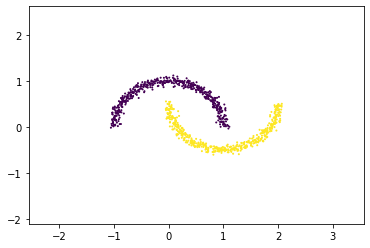

In [ ]:
#@title Prepare Data and Specify Input Domain

# prepare data

from sklearn.datasets import make_moons, make_circles, make_blobs

dataloader = make_dataloader(make_moons,1000)

# get upper and lower bounds
xlow,ylow = dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

# ROI square domain at the input space
pad = 1.5
domain = torch.tensor([
    [xlow,ylow],
    [xlow,yhigh],
    [xhigh,yhigh],
    [xhigh,ylow],
    [xlow,ylow]
])

domain += np.sign(domain)*1.5

# Get projection matrix for 2D<->input
T = torch.eye(3)[:-1]

## plot data and set domain boundaries
plt.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
            dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
            c = dataloader.__dict__['dataset'][:,-1].numpy(),s=1,
           )
plt.xlim([domain[0][0],domain[2][0]])
plt.ylim([domain[0][1],domain[2][1]])

In [ ]:
#@title Specify Network

width = 10
depth = 5

model = nn.Sequential(
    nn.Linear(2,width),
    nn.ReLU(),
    *[nn.Linear(width,width), nn.ReLU()]*(depth-2),
    nn.Linear(width,1),
)

model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=1, bias=True)
)

Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 20.51it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 562.34it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 233.09it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 459.11it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 272.41it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 454.59it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 386.39it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 329.57it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 403.33it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 38.30it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 274.16it/s]

Get Abw: 100%|██████████| 18/18 [00:00<00:00, 48.42it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 51.85it/s]


Time elapsed 0.102 minutes
tensor([0])


100%|██████████| 367/367 [00:00<00:00, 1411.61it/s]


Epoch: 1, Loss: 0.6933371797204018
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 19.84it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 340.71it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 352.31it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 607.89it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 372.10it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 314.73it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 428.54it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 59.44it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 687.93it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 412.35it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 393.72it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 334.93it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 330.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 365.60it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 49.34it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 75.14it/s]

Time elapsed 0.085 minutes


tensor([0])


100%|██████████| 379/379 [00:00<00:00, 2751.83it/s]


Epoch: 2, Loss: 0.6922925338149071
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 18.89it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 421.86it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 653.59it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 452.02it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 447.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 512.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 318.12it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 397.22it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 271.00it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 57.18it/s]


Current layer 3


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 533.51it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 283.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 390.00it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 450.19it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 50.04it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 317.54it/s]

Get Abw: 100%|██████████| 25/25 [00:00<00:00, 51.31it/s]

Time elapsed 0.094 minutes


tensor([0])


100%|██████████| 395/395 [00:00<00:00, 1589.74it/s]


Epoch: 3, Loss: 0.691264234483242
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.76it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 387.04it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 367.14it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 466.28it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 414.06it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 371.36it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 410.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 392.80it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 345.19it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 308.47it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 55.05it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 250.51it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 244.27it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 314.55it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 78.24it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 77.01it/s]

Time elapsed 0.088 minutes


tensor([0])


100%|██████████| 385/385 [00:00<00:00, 1396.63it/s]


Epoch: 4, Loss: 0.6903597787022591
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 19.27it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 372.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 334.90it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 432.24it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 417.99it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 389.81it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 319.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 377.90it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 178.79it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 56.51it/s]


Current layer 3


iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 428.45it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 76.43it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 53.74it/s]

Time elapsed 0.087 minutes


tensor([0])


100%|██████████| 388/388 [00:00<00:00, 1676.52it/s]


Epoch: 5, Loss: 0.6894347444176674
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.52it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 324.49it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 193.13it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 309.76it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 310.24it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 466.55it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 289.30it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 246.83it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 410.80it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 38.49it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 250.38it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 297.02it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 248.10it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 72.02it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 77.62it/s]

Time elapsed 0.097 minutes


tensor([0])


100%|██████████| 371/371 [00:00<00:00, 2659.57it/s]


Epoch: 6, Loss: 0.6882281228899956
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 19.51it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 381.92it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 451.25it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 296.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 339.96it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 477.62it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 372.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 279.69it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 510.82it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 56.83it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 266.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.94it/s]

Get Abw: 100%|██████████| 18/18 [00:00<00:00, 69.93it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 70.33it/s]

Time elapsed 0.090 minutes


tensor([0])


100%|██████████| 367/367 [00:00<00:00, 848.73it/s]


Epoch: 7, Loss: 0.6865778937935829
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 229.05it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 279.52it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 240.49it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 227.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 284.49it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 27.59it/s]


Current layer 3


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 302.72it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 40.65it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 67.62it/s]

Time elapsed 0.136 minutes


tensor([0])


100%|██████████| 374/374 [00:00<00:00, 2625.09it/s]


Epoch: 8, Loss: 0.6843616589903831
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 19.16it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 324.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 471.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 529.67it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 347.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 198.05it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 218.73it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 178.35it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 385.97it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 50.99it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 344.44it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 270.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 348.38it/s]

Get Abw: 100%|██████████| 19/19 [00:00<00:00, 74.38it/s]

Current layer 4



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 272.98it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 68.74it/s]

Time elapsed 0.085 minutes


tensor([0])


100%|██████████| 379/379 [00:00<00:00, 2567.81it/s]


Epoch: 9, Loss: 0.6814225241541862
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 17.14it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 380.00it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 214.17it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 350.53it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 662.69it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 445.49it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 416.78it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 270.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 216.25it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 317.89it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 424.81it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 41.08it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 321.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 438.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 306.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 341.14it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 51.56it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 49.76it/s]

Time elapsed 0.110 minutes


tensor([0])


100%|██████████| 398/398 [00:00<00:00, 1639.47it/s]


Epoch: 10, Loss: 0.6774255782365799
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 19.17it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 557.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 361.04it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 406.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 463.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 344.07it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 637.26it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 465.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 282.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 344.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 625.50it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 51.05it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 369.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 264.15it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 397.21it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.05it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 334.17it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 74.71it/s]

Current layer 4



Get Abw: 100%|██████████| 26/26 [00:00<00:00, 73.87it/s]

Time elapsed 0.088 minutes


tensor([0])


100%|██████████| 406/406 [00:00<00:00, 1139.78it/s]


Epoch: 11, Loss: 0.6720736995339394
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 17.75it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 306.60it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 518.63it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.89it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 334.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 206.52it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 520.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 347.46it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 214.00it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 53.31it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 352.83it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 372.65it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 328.56it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 578.70it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 52.22it/s]

Current layer 4



Get Abw: 100%|██████████| 26/26 [00:00<00:00, 53.62it/s]

Time elapsed 0.104 minutes


tensor([0])


100%|██████████| 413/413 [00:00<00:00, 1521.24it/s]


Epoch: 12, Loss: 0.6651441976428032
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 18.70it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 304.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 355.05it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 437.09it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 462.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 665.94it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 376.22it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 343.14it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 379.94it/s]

Get Abw: 100%|██████████| 11/11 [00:00<00:00, 52.15it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 371.44it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 538.66it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 350.34it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 229.65it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 285.57it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 432.16it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 79.04it/s]

Current layer 4



Get Abw: 100%|██████████| 27/27 [00:00<00:00, 79.33it/s]

Time elapsed 0.090 minutes


tensor([0])


100%|██████████| 432/432 [00:00<00:00, 2595.33it/s]


Epoch: 13, Loss: 0.6565232202410698
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 15.95it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 271.28it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 689.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 488.71it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 307.42it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 399.53it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 570.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 288.74it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 211.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 341.48it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 48.76it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 317.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 367.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 372.80it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 378.60it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 487.87it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 388.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 543.56it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 189.96it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 551.79it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 591.81it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 62.03it/s]

Current layer 4



Get Abw: 100%|██████████| 27/27 [00:00<00:00, 53.87it/s]

Time elapsed 0.103 minutes


tensor([0])


100%|██████████| 432/432 [00:00<00:00, 1588.82it/s]


Epoch: 14, Loss: 0.6463667377829552
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.86it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 739.70it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 341.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.03it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 275.24it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 217.65it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 246.24it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 50.14it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 574.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 345.11it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 379.02it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 360.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 384.01it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 325.25it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 229.04it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 232.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 385.61it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 73.78it/s]

Current layer 4



Get Abw: 100%|██████████| 27/27 [00:00<00:00, 80.30it/s] 

Time elapsed 0.093 minutes


tensor([0])


100%|██████████| 420/420 [00:00<00:00, 971.31it/s] 


Epoch: 15, Loss: 0.6345135048031807
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 16.21it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 352.84it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 247.17it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 394.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 532.81it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 262.55it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 401.10it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 358.20it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 48.83it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 404.54it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 545.16it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 569.32it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 291.51it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 346.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 451.07it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 338.15it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 362.67it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 224.68it/s]

Get Abw: 100%|██████████| 18/18 [00:00<00:00, 69.02it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.35it/s]

Get Abw: 100%|██████████| 25/25 [00:00<00:00, 51.50it/s]

Time elapsed 0.098 minutes


tensor([0])


100%|██████████| 391/391 [00:00<00:00, 1555.43it/s]


Epoch: 16, Loss: 0.620248019695282
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 12.17it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 351.92it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 243.25it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 298.25it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 453.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 272.92it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 370.42it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 47.75it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 559.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 261.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 294.57it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 290.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 420.95it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 263.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 239.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 381.83it/s]

Get Abw: 100%|██████████| 18/18 [00:00<00:00, 66.76it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 74.07it/s]

Time elapsed 0.094 minutes


tensor([0])


100%|██████████| 372/372 [00:00<00:00, 2711.05it/s]


Epoch: 17, Loss: 0.6030147150158882
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 16.05it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 293.13it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 276.31it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 262.31it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 425.21it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 354.01it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 378.36it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 618.58it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 404.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 463.36it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 46.13it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 231.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 393.83it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 369.85it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 246.98it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 62.58it/s]

Current layer 4



Get Abw: 100%|██████████| 22/22 [00:00<00:00, 54.26it/s]

Time elapsed 0.086 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 1743.65it/s]


Epoch: 18, Loss: 0.5823045372962952
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.50it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 359.30it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 189.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 287.84it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 375.30it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 466.58it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 32.20it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 275.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 524.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 336.43it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 58.52it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 273.11it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 67.38it/s]


Time elapsed 0.103 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2507.13it/s]


Epoch: 19, Loss: 0.5584086030721664
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 21.10it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 438.47it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 338.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 405.63it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 288.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.97it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 429.80it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 45.61it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 335.71it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 442.02it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 312.63it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 58.01it/s]

Current layer 4



Get Abw: 100%|██████████| 22/22 [00:00<00:00, 67.87it/s]

Time elapsed 0.084 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2201.27it/s]


Epoch: 20, Loss: 0.5309057384729385
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 298.71it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 298.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 536.48it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 453.18it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 332.31it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 30.21it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 190.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 430.42it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 331.92it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 37.90it/s]

Current layer 4



Get Abw: 100%|██████████| 21/21 [00:00<00:00, 66.78it/s]

Time elapsed 0.113 minutes


tensor([0])


Iterating regions: 100%|██████████| 20/20 [00:00<00:00, 988.88it/s]
<ipython-input-9-520f06560157>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
100%|██████████| 334/334 [00:00<00:00, 2557.03it/s]


Epoch: 21, Loss: 0.5006401315331459
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 20.95it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 506.90it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 418.19it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 302.16it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 214.97it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 370.86it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 45.26it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 427.19it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 344.79it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 441.18it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 59.25it/s]

Current layer 4



Get Abw: 100%|██████████| 21/21 [00:00<00:00, 67.11it/s]

Time elapsed 0.082 minutes


tensor([0])


100%|██████████| 330/330 [00:00<00:00, 2554.31it/s]


Epoch: 22, Loss: 0.46873828768730164
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 20.73it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 331.97it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 252.65it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 167.94it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 635.15it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 29.96it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 291.70it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 37.27it/s]

Current layer 4



Get Abw: 100%|██████████| 21/21 [00:00<00:00, 45.72it/s]


Time elapsed 0.105 minutes
tensor([0])


100%|██████████| 329/329 [00:00<00:00, 2072.88it/s]


Epoch: 23, Loss: 0.4364040642976761
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 20.26it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 274.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 503.14it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 249.49it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 311.39it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 417.13it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 208.40it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 44.83it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 192.17it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 557.36it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 256.29it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 407.97it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 313.69it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 60.29it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 285.83it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 249.60it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 71.35it/s]

Time elapsed 0.086 minutes


tensor([0])


100%|██████████| 367/367 [00:00<00:00, 2414.24it/s]


Epoch: 24, Loss: 0.40506744012236595
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s]


Current layer 2


iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 311.89it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 550.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 330.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 407.07it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 274.69it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 45.79it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 420.40it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 342.17it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 203.57it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 37.24it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 630.27it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 399.50it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 52.89it/s]


Time elapsed 0.103 minutes
tensor([0])


100%|██████████| 378/378 [00:00<00:00, 1592.72it/s]


Epoch: 25, Loss: 0.37601163610816
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Current layer 2


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 483.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 296.35it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 164.67it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 40.19it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 274.31it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 617.42it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 243.64it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 55.81it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 473.16it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 556.98it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 353.69it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 642.36it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 72.95it/s] 


Time elapsed 0.090 minutes
tensor([0])


100%|██████████| 366/366 [00:00<00:00, 2591.58it/s]


Epoch: 26, Loss: 0.35000957921147346
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 15.21it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 321.07it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 451.57it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 172.75it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 38.87it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 609.08it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 300.12it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 297.73it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 51.92it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 384.67it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 379.01it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 223.82it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 50.93it/s]

Time elapsed 0.094 minutes


tensor([0])


100%|██████████| 374/374 [00:00<00:00, 1679.02it/s]


Epoch: 27, Loss: 0.32737166434526443
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.48it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 297.66it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 325.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 417.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 294.34it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 39.36it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 206.93it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 331.63it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 55.85it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 389.20it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 400.78it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 74.03it/s] 

Time elapsed 0.098 minutes


tensor([0])


100%|██████████| 374/374 [00:00<00:00, 2541.06it/s]


Epoch: 28, Loss: 0.30796494521200657
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 14.99it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 316.93it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 335.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 251.44it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 38.90it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 239.35it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 329.43it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 318.92it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 583.70it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 56.05it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 593.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 420.31it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 413.03it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 52.76it/s]

Time elapsed 0.093 minutes


tensor([0])


100%|██████████| 370/370 [00:00<00:00, 476.40it/s]


Epoch: 29, Loss: 0.2913123946636915
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 300.74it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 318.50it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 579.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 257.37it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 39.22it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 352.14it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 710.00it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 55.20it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 539.08it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 626.41it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 338.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.06it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 70.91it/s]

Time elapsed 0.099 minutes


tensor([0])


100%|██████████| 364/364 [00:00<00:00, 2331.44it/s]


Epoch: 30, Loss: 0.27677961252629757
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 15.51it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 290.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 382.16it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 311.46it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 39.21it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 315.62it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 54.56it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 406.13it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 805.11it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 49.52it/s]

Time elapsed 0.089 minutes


tensor([0])


100%|██████████| 368/368 [00:00<00:00, 1686.64it/s]


Epoch: 31, Loss: 0.2639115434139967
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.21it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 294.29it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 220.09it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 337.45it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 30.78it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 360.08it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 382.30it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 55.97it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 534.70it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 68.87it/s]

Time elapsed 0.106 minutes


tensor([0])


100%|██████████| 360/360 [00:00<00:00, 2516.31it/s]


Epoch: 32, Loss: 0.2524688635021448
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.07it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 203.68it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 335.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 333.36it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 390.07it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 26.09it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 272.73it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 33.81it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 432.44it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 398.56it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 48.64it/s]

Time elapsed 0.125 minutes


tensor([0])


100%|██████████| 354/354 [00:00<00:00, 1741.69it/s]


Epoch: 33, Loss: 0.24230403266847134
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.56it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 192.69it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 387.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 276.60it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 31.69it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 360.04it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 388.79it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 54.87it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 423.55it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 362.28it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 391.03it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 67.69it/s]

Time elapsed 0.101 minutes


tensor([0])


100%|██████████| 354/354 [00:00<00:00, 2448.91it/s]


Epoch: 34, Loss: 0.23329253308475018
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 14.57it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 271.11it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 319.27it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 209.70it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 34.56it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 355.02it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 463.31it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 55.02it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 362.14it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 487.93it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 406.72it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 55.30it/s]

Time elapsed 0.090 minutes


tensor([0])


100%|██████████| 360/360 [00:00<00:00, 1813.58it/s]


Epoch: 35, Loss: 0.22517068777233362
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 196.25it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 270.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 286.93it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.69it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 267.56it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 53.04it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 460.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 410.78it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 384.35it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 568.84it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 67.93it/s]

Time elapsed 0.110 minutes


tensor([0])


100%|██████████| 362/362 [00:00<00:00, 2329.30it/s]


Epoch: 36, Loss: 0.21782710123807192
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.94it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 317.02it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 415.24it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 34.40it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.94it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 493.17it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 52.60it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 338.55it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 513.03it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 301.98it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 65.21it/s]

Time elapsed 0.090 minutes


tensor([0])


100%|██████████| 363/363 [00:00<00:00, 1616.90it/s]


Epoch: 37, Loss: 0.21106246206909418
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 249.46it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 265.56it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.73it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 299.92it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.43it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 448.25it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 54.47it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 681.73it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 411.68it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 569.79it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 65.51it/s]

Time elapsed 0.115 minutes


tensor([0])


100%|██████████| 356/356 [00:00<00:00, 486.52it/s] 


Epoch: 38, Loss: 0.20478933490812778
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 14.07it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 263.06it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 291.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 256.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 516.24it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 561.99it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 34.06it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 258.33it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 225.66it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 228.55it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.82it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 53.63it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 501.82it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 427.80it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 501.74it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 70.43it/s] 

Time elapsed 0.090 minutes


tensor([0])


100%|██████████| 354/354 [00:00<00:00, 1755.69it/s]


Epoch: 39, Loss: 0.19888194743543863
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 353.55it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 452.77it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.57it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 238.01it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 410.27it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 227.43it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 52.09it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 353.98it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 490.57it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 66.02it/s]

Time elapsed 0.115 minutes


tensor([0])


100%|██████████| 351/351 [00:00<00:00, 2377.65it/s]


Epoch: 40, Loss: 0.19291774276643991
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 14.14it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 282.73it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 361.89it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 462.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.13it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 30.56it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 382.13it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 249.90it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 309.03it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 52.22it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 949.58it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 1017.24it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 63.93it/s]

Time elapsed 0.093 minutes


tensor([0])


100%|██████████| 349/349 [00:00<00:00, 2363.98it/s]


Epoch: 41, Loss: 0.18630038760602474
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 275.70it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 217.93it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 405.69it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 456.38it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.26it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 248.72it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.64it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 52.19it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 574.61it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 414.35it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 376.60it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 65.13it/s]

Time elapsed 0.121 minutes


tensor([0])


100%|██████████| 350/350 [00:00<00:00, 2256.92it/s]


Epoch: 42, Loss: 0.17898720409721136
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.79it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 284.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 286.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 342.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 498.45it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 467.30it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 32.37it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 307.85it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 332.80it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 351.05it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 52.56it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 342.75it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 60.62it/s]

Time elapsed 0.093 minutes


tensor([0])


100%|██████████| 349/349 [00:00<00:00, 2426.69it/s]


Epoch: 43, Loss: 0.1713870521634817
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 330.66it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 224.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 260.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 424.70it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 203.87it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 368.43it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 23.11it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 221.83it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 299.81it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 32.29it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 349.93it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 331.82it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 67.62it/s]

Time elapsed 0.126 minutes


tensor([0])


100%|██████████| 356/356 [00:00<00:00, 2255.04it/s]


Epoch: 44, Loss: 0.16374907083809376
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.70it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 310.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 249.82it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 177.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 355.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 501.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 324.97it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 365.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 260.49it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 31.14it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 305.75it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 215.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 409.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 461.13it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 53.33it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 64.48it/s]

Time elapsed 0.096 minutes


tensor([0])


100%|██████████| 359/359 [00:00<00:00, 2315.53it/s]


Epoch: 45, Loss: 0.15630551613867283
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 449.34it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 439.39it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 472.63it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 219.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 238.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 292.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 317.66it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.34it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 232.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 312.48it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 35.63it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 408.20it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 64.87it/s]

Time elapsed 0.128 minutes


tensor([0])


100%|██████████| 366/366 [00:00<00:00, 2372.40it/s]


Epoch: 46, Loss: 0.14921299181878567
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.28it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 284.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 458.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 430.19it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 234.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 227.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 426.94it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 31.93it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 333.24it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 373.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 476.63it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 56.22it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 62.79it/s]

Time elapsed 0.096 minutes


tensor([0])


100%|██████████| 367/367 [00:00<00:00, 2390.38it/s]


Epoch: 47, Loss: 0.14253733772784472
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 319.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 321.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 494.75it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 271.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 279.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 515.52it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 19.60it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 442.82it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 281.32it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 386.71it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 33.75it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 467.46it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 65.11it/s]

Time elapsed 0.128 minutes


tensor([0])


100%|██████████| 378/378 [00:00<00:00, 2534.49it/s]


Epoch: 48, Loss: 0.13598763151094317
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 13.03it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 390.83it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 345.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 450.32it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 515.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 413.86it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 491.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 450.53it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 29.85it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 205.74it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 323.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 453.62it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 54.15it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 65.12it/s]

Time elapsed 0.097 minutes


tensor([0])


100%|██████████| 377/377 [00:00<00:00, 2485.44it/s]


Epoch: 49, Loss: 0.12957671470940113
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 247.66it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 343.04it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 334.47it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 324.65it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 431.92it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 378.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 470.49it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.33it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 290.08it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 265.62it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 34.08it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 65.60it/s]

Time elapsed 0.138 minutes


tensor([0])


100%|██████████| 373/373 [00:00<00:00, 2478.68it/s]


Epoch: 50, Loss: 0.12328292429447174
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 12.25it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 386.10it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.25it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 296.46it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 423.15it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 268.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 470.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 400.23it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 31.69it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 313.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 319.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 458.80it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 53.56it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.82it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 538.39it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 60.38it/s]

Time elapsed 0.099 minutes


tensor([0])


100%|██████████| 374/374 [00:00<00:00, 2359.26it/s]


Epoch: 51, Loss: 0.11703308671712875
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 371.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 268.72it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 255.60it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 252.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 268.48it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.17it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 272.66it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 158.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 255.75it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 56.70it/s]

Current layer 4



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 233.95it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 61.58it/s]

Time elapsed 0.135 minutes


tensor([0])


100%|██████████| 379/379 [00:00<00:00, 2393.65it/s]


Epoch: 52, Loss: 0.11089816456660628
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 12.56it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 343.82it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 255.88it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 403.73it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 299.75it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 415.21it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 416.14it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 29.55it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 195.59it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 262.27it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 53.79it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 63.08it/s]

Time elapsed 0.098 minutes


tensor([0])


100%|██████████| 375/375 [00:00<00:00, 2487.25it/s]


Epoch: 53, Loss: 0.10488550830632448
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 342.73it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 367.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 404.53it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 205.10it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 273.34it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 381.50it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 19.98it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 169.65it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 302.80it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 55.11it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 61.21it/s]

Time elapsed 0.129 minutes


tensor([0])


100%|██████████| 373/373 [00:00<00:00, 2603.67it/s]


Epoch: 54, Loss: 0.0989819117821753
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 12.56it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.32it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 299.07it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 343.20it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 332.12it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 424.73it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 480.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.97it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 482.79it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 30.21it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.21it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 292.14it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 62.61it/s]

Time elapsed 0.101 minutes


tensor([0])


100%|██████████| 374/374 [00:00<00:00, 1664.79it/s]


Epoch: 55, Loss: 0.09321942226961255
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 265.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 333.96it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 429.41it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 229.18it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 337.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 497.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 391.26it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 17.18it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 200.53it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 283.69it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 30.69it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 41.99it/s]

Time elapsed 0.162 minutes


tensor([0])


100%|██████████| 382/382 [00:00<00:00, 2543.58it/s]


Epoch: 56, Loss: 0.0876070512458682
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.85it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.33it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 407.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 479.60it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 272.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 428.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 312.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 342.08it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 32.97it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 527.82it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 278.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.61it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.81it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 323.70it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 53.46it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 62.77it/s]

Time elapsed 0.104 minutes


tensor([0])


100%|██████████| 385/385 [00:00<00:00, 1586.71it/s]


Epoch: 57, Loss: 0.08216351922601461
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 434.78it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 299.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 264.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 266.64it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 333.58it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 19.52it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 318.72it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 293.04it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 55.27it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 60.37it/s]

Time elapsed 0.123 minutes


tensor([0])


100%|██████████| 380/380 [00:00<00:00, 2580.42it/s]


Epoch: 58, Loss: 0.07689988450147212
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.68it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 581.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 509.59it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 328.62it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 333.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 529.45it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 435.51it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.29it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 29.93it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 312.87it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 49.85it/s]


Current layer 4


Get Abw: 100%|██████████| 24/24 [00:00<00:00, 42.99it/s]

Time elapsed 0.108 minutes


tensor([0])


100%|██████████| 378/378 [00:00<00:00, 1613.32it/s]


Epoch: 59, Loss: 0.07181783951818943
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 439.63it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 277.13it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 264.46it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 388.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 301.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.34it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 29.91it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 291.55it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 50.46it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 60.64it/s]

Time elapsed 0.115 minutes


tensor([0])


100%|██████████| 382/382 [00:00<00:00, 2493.10it/s]


Epoch: 60, Loss: 0.06692977785132825
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.64it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 582.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 328.82it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 298.38it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 427.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 461.71it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 350.86it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 426.71it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 29.48it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 210.68it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 206.13it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 36.77it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 41.43it/s]


Time elapsed 0.121 minutes
tensor([0])


100%|██████████| 385/385 [00:00<00:00, 1440.14it/s]


Epoch: 61, Loss: 0.06225891620852053
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.64it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 394.81it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 253.18it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 320.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 368.59it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 379.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 441.82it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 27.63it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 414.57it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 341.25it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 63.33it/s]

Time elapsed 0.104 minutes


tensor([0])


100%|██████████| 389/389 [00:00<00:00, 2553.14it/s]


Epoch: 62, Loss: 0.05783062591217458
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 540.45it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 343.41it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 309.11it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 357.82it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 463.03it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 353.75it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 26.50it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 356.63it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 334.54it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 33.13it/s]


Current layer 4


Get Abw: 100%|██████████| 25/25 [00:00<00:00, 40.94it/s]


Time elapsed 0.134 minutes
tensor([0])


100%|██████████| 394/394 [00:01<00:00, 360.10it/s]


Epoch: 63, Loss: 0.053622832987457514
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 636.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.42it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 284.86it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 454.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 460.64it/s]

Get Abw: 100%|██████████| 9/9 [00:00<00:00, 32.71it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 363.65it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 420.01it/s]

Get Abw: 100%|██████████| 17/17 [00:00<00:00, 50.00it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 61.90it/s]

Time elapsed 0.105 minutes


tensor([0])


100%|██████████| 400/400 [00:00<00:00, 2453.97it/s]


Epoch: 64, Loss: 0.04964972450397909
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 478.72it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.31it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 304.10it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 484.01it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 197.67it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 258.76it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 33.79it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 61.48it/s]

Time elapsed 0.140 minutes


tensor([0])


100%|██████████| 393/393 [00:00<00:00, 2433.05it/s]


Epoch: 65, Loss: 0.045935391332022846
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.89it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 587.40it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.60it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.44it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 295.24it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 348.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 351.36it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 27.71it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 474.67it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 359.41it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 49.20it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 61.52it/s]

Time elapsed 0.105 minutes


tensor([0])


100%|██████████| 391/391 [00:00<00:00, 1516.32it/s]


Epoch: 66, Loss: 0.04246950417291373
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s]

Current layer 2



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 416.49it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 210.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 244.46it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 327.47it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 341.94it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 300.28it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 48.25it/s]

Current layer 4



Get Abw: 100%|██████████| 25/25 [00:00<00:00, 58.59it/s]

Time elapsed 0.135 minutes


tensor([0])


100%|██████████| 392/392 [00:00<00:00, 2473.19it/s]


Epoch: 67, Loss: 0.0392298367805779
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.44it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 528.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 425.88it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 432.60it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 328.15it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 492.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.37it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 27.34it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 217.39it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 421.75it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 311.15it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 451.40it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 48.92it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 39.10it/s]

Time elapsed 0.112 minutes


tensor([0])


100%|██████████| 383/383 [00:00<00:00, 1541.89it/s]


Epoch: 68, Loss: 0.0362157030031085
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 298.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 473.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 510.32it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 318.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 457.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 425.18it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 27.13it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 338.02it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 305.02it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 316.25it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 445.24it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 48.87it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.41it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 59.17it/s]

Time elapsed 0.117 minutes


tensor([0])


100%|██████████| 379/379 [00:00<00:00, 2422.33it/s]


Epoch: 69, Loss: 0.033425645204260945
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 11.25it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 652.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 485.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 426.22it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 360.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 464.42it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 461.45it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 26.12it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 185.27it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 308.00it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 269.82it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 30.91it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.00it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 37.60it/s]


Time elapsed 0.132 minutes
tensor([0])


100%|██████████| 376/376 [00:00<00:00, 1604.49it/s]


Epoch: 70, Loss: 0.030825087684206665
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.10it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 523.47it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 461.94it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 528.32it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 320.23it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 423.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 585.31it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 27.32it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 340.09it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 292.03it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 289.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 529.58it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 47.41it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 454.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 425.53it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 57.33it/s]

Time elapsed 0.109 minutes


tensor([0])


100%|██████████| 375/375 [00:00<00:00, 2191.29it/s]


Epoch: 71, Loss: 0.028425209689885378
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.74it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 383.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 435.50it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 313.99it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 287.08it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 292.02it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 484.65it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.19it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 289.18it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 210.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 320.42it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 31.99it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 362.54it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 57.41it/s]

Time elapsed 0.143 minutes


tensor([0])


100%|██████████| 370/370 [00:00<00:00, 2118.32it/s]


Epoch: 72, Loss: 0.026234479737468064
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.90it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 449.78it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.22it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 295.06it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 355.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 429.70it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 288.45it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 435.70it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 26.90it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 241.95it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 313.00it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 248.56it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 45.38it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 57.47it/s]

Time elapsed 0.111 minutes


tensor([0])


100%|██████████| 370/370 [00:00<00:00, 2373.40it/s]


Epoch: 73, Loss: 0.024223606567829847
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 342.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 449.04it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 419.14it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 418.00it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 308.39it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 174.59it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 237.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 270.81it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 39.74it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 529.18it/s]

Get Abw: 100%|██████████| 24/24 [00:00<00:00, 59.60it/s]

Time elapsed 0.143 minutes


tensor([0])


100%|██████████| 372/372 [00:00<00:00, 2438.34it/s]


Epoch: 74, Loss: 0.022369353682734072
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.81it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 511.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.35it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 293.46it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 308.31it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 430.96it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 26.39it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 275.97it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 315.84it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 277.80it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 45.83it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 56.54it/s]

Time elapsed 0.109 minutes


tensor([0])


100%|██████████| 375/375 [00:00<00:00, 1676.11it/s]


Epoch: 75, Loss: 0.02068269718438387
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 441.04it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 370.03it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 281.71it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 301.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 387.68it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.97it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 232.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 129.73it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 319.96it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 47.07it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 56.40it/s]

Time elapsed 0.134 minutes


tensor([0])


100%|██████████| 376/376 [00:00<00:00, 2222.54it/s]


Epoch: 76, Loss: 0.01915079663740471
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.94it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 369.25it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.56it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 331.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 286.09it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 267.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 334.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 346.63it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 23.78it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 39.84it/s]

Time elapsed 0.168 minutes


tensor([0])


100%|██████████| 376/376 [00:00<00:00, 1578.82it/s]


Epoch: 77, Loss: 0.017744180629961193
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.58it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 470.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 481.64it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 399.31it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 247.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 357.79it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.64it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 392.49it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 283.77it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 342.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 364.60it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 45.54it/s]

Current layer 4



Get Abw: 100%|██████████| 24/24 [00:00<00:00, 59.21it/s]

Time elapsed 0.111 minutes


tensor([0])


100%|██████████| 370/370 [00:00<00:00, 2279.79it/s]


Epoch: 78, Loss: 0.016445020446553826
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 359.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 402.01it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 279.00it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.20it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 316.71it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 221.76it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 30.38it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 53.79it/s]

Time elapsed 0.148 minutes


tensor([0])


100%|██████████| 366/366 [00:01<00:00, 278.95it/s]


Epoch: 79, Loss: 0.015218916581943631
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.30it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 350.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 478.17it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 393.81it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 342.43it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 25.45it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 498.59it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 45.81it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 54.71it/s]

Time elapsed 0.111 minutes


tensor([0])


100%|██████████| 357/357 [00:00<00:00, 1771.72it/s]


Epoch: 80, Loss: 0.014094749349169433
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 400.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 360.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 362.64it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 218.77it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]

Current layer 3



Get Abw: 100%|██████████| 16/16 [00:00<00:00, 42.61it/s]

Current layer 4



Get Abw: 100%|██████████| 23/23 [00:00<00:00, 54.29it/s]

Time elapsed 0.137 minutes


tensor([0])


100%|██████████| 358/358 [00:00<00:00, 2200.10it/s]


Epoch: 81, Loss: 0.013076374190859497
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 606.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 418.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.11it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 391.21it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 285.75it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 405.55it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.87it/s]

Current layer 3



Get Abw: 100%|██████████| 16/16 [00:00<00:00, 42.25it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 378.97it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 36.24it/s]

Time elapsed 0.125 minutes


tensor([0])


100%|██████████| 358/358 [00:00<00:00, 1519.12it/s]


Epoch: 82, Loss: 0.012175140727777034
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.35it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 582.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 463.39it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 457.19it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 410.74it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 312.75it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 437.16it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 25.43it/s]

Current layer 3



Get Abw: 100%|██████████| 16/16 [00:00<00:00, 43.03it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 493.62it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 52.05it/s]

Time elapsed 0.118 minutes


tensor([0])


100%|██████████| 358/358 [00:00<00:00, 2317.76it/s]


Epoch: 83, Loss: 0.01137038110755384
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.47it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 425.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 444.66it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 409.07it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 281.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 483.53it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s]


Current layer 3


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 421.76it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 29.50it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 313.88it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 303.56it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 41.30it/s]


Time elapsed 0.145 minutes
tensor([0])


100%|██████████| 356/356 [00:00<00:00, 2188.30it/s]


Epoch: 84, Loss: 0.010623809532262385
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.34it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 416.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 393.38it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 406.56it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 405.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 250.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 428.94it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.81it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 624.90it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 42.82it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 495.00it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 52.36it/s]

Time elapsed 0.115 minutes


tensor([0])


100%|██████████| 359/359 [00:00<00:00, 2341.17it/s]


Epoch: 85, Loss: 0.009944888355676085
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 606.38it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 353.50it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 315.51it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 249.36it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 460.42it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 43.37it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 370.98it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 374.18it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 667.06it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 51.88it/s]

Time elapsed 0.153 minutes


tensor([0])


100%|██████████| 361/361 [00:00<00:00, 2022.12it/s]


Epoch: 86, Loss: 0.009334194590337574
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.52it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 595.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 468.74it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 428.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 477.17it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 285.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 451.73it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 25.23it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 505.36it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 617.26it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 44.57it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 411.03it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 467.54it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 433.89it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 38.38it/s]

Time elapsed 0.122 minutes


tensor([0])


100%|██████████| 365/365 [00:00<00:00, 1598.74it/s]


Epoch: 87, Loss: 0.008777762006502599
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 624.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 317.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 393.31it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 407.83it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 392.42it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 25.08it/s]

Current layer 3



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.69it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 561.86it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 42.99it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 444.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 470.46it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 596.99it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 53.32it/s]

Time elapsed 0.128 minutes


tensor([0])


100%|██████████| 364/364 [00:00<00:00, 2358.46it/s]


Epoch: 88, Loss: 0.008267867495305836
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 10.30it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 509.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 462.56it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 389.88it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 419.56it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 301.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 430.05it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.06it/s]


Current layer 3


iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 659.46it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 719.90it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 29.12it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 370.83it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 319.43it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 34.68it/s]

Time elapsed 0.146 minutes


tensor([0])


100%|██████████| 363/363 [00:00<00:00, 2433.26it/s]


Epoch: 89, Loss: 0.007799068436725065
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 420.76it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 444.05it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 369.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 418.55it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.11it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 321.95it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 367.21it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 388.62it/s]

Get Abw: 100%|██████████| 16/16 [00:00<00:00, 41.17it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 362.32it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 51.58it/s]

Time elapsed 0.117 minutes


tensor([0])


100%|██████████| 359/359 [00:00<00:00, 2370.96it/s]


Epoch: 90, Loss: 0.0073701851069927216
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 432.06it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 427.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 349.13it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.96it/s]

Current layer 3



Get Abw: 100%|██████████| 16/16 [00:00<00:00, 32.01it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 386.94it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 338.05it/s]

Get Abw: 100%|██████████| 23/23 [00:00<00:00, 54.31it/s]

Time elapsed 0.147 minutes


tensor([0])


100%|██████████| 355/355 [00:00<00:00, 2216.64it/s]


Epoch: 91, Loss: 0.006976267963182181
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.95it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 343.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 393.67it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 367.79it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 442.06it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.37it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 458.97it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 39.55it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 402.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.63it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 34.95it/s]


Time elapsed 0.119 minutes
tensor([0])


100%|██████████| 351/351 [00:00<00:00, 1501.82it/s]


Epoch: 92, Loss: 0.00661359095829539
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 476.77it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 402.23it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 327.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 389.24it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.82it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 654.64it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 41.72it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 403.21it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 320.09it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 51.78it/s]

Time elapsed 0.129 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2382.96it/s]


Epoch: 93, Loss: 0.006277819455135614
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 581.96it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 270.08it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 262.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 454.86it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.85it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 308.29it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.82it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 273.73it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 318.02it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 32.81it/s]

Time elapsed 0.143 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2444.80it/s]


Epoch: 94, Loss: 0.005966962547972798
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.88it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 564.87it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 400.48it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 308.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 479.04it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.60it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 583.43it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 41.87it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 327.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 432.16it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 50.27it/s]

Time elapsed 0.115 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2248.69it/s]


Epoch: 95, Loss: 0.005680771952029318
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 376.04it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 435.38it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 322.10it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 470.49it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 22.74it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 442.14it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 380.18it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

Time elapsed 0.184 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2397.25it/s]


Epoch: 96, Loss: 0.005415355321019888
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 421.18it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 311.21it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 249.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 445.84it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.91it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 512.59it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 40.67it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 388.84it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 335.29it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 50.46it/s]

Time elapsed 0.118 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2250.42it/s]


Epoch: 97, Loss: 0.00516877812333405
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 344.73it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 238.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 289.22it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.25it/s]

Current layer 3



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 244.74it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 31.01it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 504.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 319.61it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 48.85it/s]

Time elapsed 0.157 minutes


tensor([0])


100%|██████████| 350/350 [00:00<00:00, 2452.85it/s]


Epoch: 98, Loss: 0.004937732854159549
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 510.77it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 299.96it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 316.96it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.19it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.46it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 535.53it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 36.77it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 486.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 505.83it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.92it/s]


Time elapsed 0.123 minutes
tensor([0])


100%|██████████| 347/347 [00:00<00:00, 1765.72it/s]


Epoch: 99, Loss: 0.004723002217360772
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 525.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 395.87it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 308.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 387.08it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 24.24it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 656.26it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 40.35it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 510.63it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.17it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 48.93it/s]

Time elapsed 0.133 minutes


tensor([0])


100%|██████████| 346/346 [00:01<00:00, 215.86it/s] 


Epoch: 100, Loss: 0.004521473805652931
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 289.25it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 419.72it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 302.31it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 409.80it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]

Current layer 3



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 411.51it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 23.33it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 420.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 335.71it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 47.31it/s]

Time elapsed 0.153 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2226.38it/s]


Epoch: 101, Loss: 0.004333499469794333
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 362.48it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 385.77it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 337.35it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 472.72it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.11it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 37.46it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 360.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 441.00it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 48.62it/s]

Time elapsed 0.118 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 1704.46it/s]


Epoch: 102, Loss: 0.0041581021214369684
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 307.54it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 330.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 344.59it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.28it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 38.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 304.63it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 480.03it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 49.24it/s]

Time elapsed 0.144 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 2226.05it/s]


Epoch: 103, Loss: 0.003992316516814753
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 420.33it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 294.84it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 431.87it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 457.49it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.26it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 29.07it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 304.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.22it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 32.06it/s]

Time elapsed 0.138 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 1422.02it/s]


Epoch: 104, Loss: 0.003837370255496353
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 482.30it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 434.28it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 266.39it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.94it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.99it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 37.48it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 429.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 408.40it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 46.99it/s]

Time elapsed 0.120 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 2225.65it/s]


Epoch: 105, Loss: 0.003691953665111214
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 387.20it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 323.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 387.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.44it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 13.12it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.71it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 406.88it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 360.07it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 48.20it/s]

Time elapsed 0.154 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 2247.59it/s]


Epoch: 106, Loss: 0.0035552197805373
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 387.81it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 269.57it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 266.72it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 399.61it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 22.59it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 36.38it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 465.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.79it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.61it/s]

Time elapsed 0.124 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 1547.54it/s]


Epoch: 107, Loss: 0.0034257977677043527
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 441.56it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 397.54it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 212.43it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 469.56it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 23.30it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 37.48it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 310.93it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.72it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 45.85it/s]

Time elapsed 0.138 minutes


tensor([0])


100%|██████████| 344/344 [00:00<00:00, 2331.26it/s]


Epoch: 108, Loss: 0.0033032071514753625
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 365.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 192.07it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 408.63it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 341.96it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.10it/s]


Current layer 4


iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 286.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 332.00it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 39.31it/s]

Time elapsed 0.156 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2087.66it/s]


Epoch: 109, Loss: 0.0031877734436420724
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 364.07it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 221.69it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 375.03it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 469.77it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 34.81it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 429.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 439.36it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 46.26it/s]


Time elapsed 0.123 minutes
tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2048.76it/s]


Epoch: 110, Loss: 0.003078629611991346
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 328.22it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 366.81it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 323.32it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 309.45it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 35.64it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 426.31it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 324.96it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.36it/s]


Time elapsed 0.154 minutes
tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2245.14it/s]


Epoch: 111, Loss: 0.0029752800473943353
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 399.55it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 315.24it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 428.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 453.06it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.78it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 24.32it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 545.44it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 410.74it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

Time elapsed 0.154 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2295.04it/s]


Epoch: 112, Loss: 0.002877377555705607
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 399.18it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 306.16it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 432.86it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 360.49it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.96it/s]


Current layer 3


Get Abw: 100%|██████████| 15/15 [00:00<00:00, 35.47it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 586.52it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 338.37it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.65it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 45.67it/s]

Time elapsed 0.125 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2248.18it/s]


Epoch: 113, Loss: 0.0027840463153552264
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 339.21it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 208.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 305.77it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 21.12it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 473.58it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]


Time elapsed 0.194 minutes
tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2353.41it/s]


Epoch: 114, Loss: 0.0026951456966344267
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 309.33it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 267.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 469.39it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 21.01it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 34.87it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 439.12it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 603.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.05it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

Time elapsed 0.140 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1496.23it/s]


Epoch: 115, Loss: 0.0026107470912393183
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 392.72it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 286.15it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 438.46it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 21.58it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 33.82it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 540.42it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 467.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 410.86it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 46.37it/s]


Time elapsed 0.134 minutes
tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2081.57it/s]


Epoch: 116, Loss: 0.002530253754230216
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 425.03it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 431.07it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 318.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 464.25it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 23.20it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 725.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 457.19it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 425.16it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 45.37it/s]


Time elapsed 0.161 minutes
tensor([0])


100%|██████████| 340/340 [00:00<00:00, 2102.79it/s]


Epoch: 117, Loss: 0.002453458757372573
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 388.05it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 295.24it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 421.69it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 21.93it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 32.45it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 788.64it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 612.08it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]


Time elapsed 0.135 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 1488.77it/s]


Epoch: 118, Loss: 0.002379986603045836
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.58it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 415.97it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 321.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.18it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 21.38it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 33.01it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 838.29it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 376.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 402.43it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.59it/s]


Time elapsed 0.138 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2104.27it/s]


Epoch: 119, Loss: 0.0023096820659702644
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 412.40it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 420.30it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 343.68it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 400.96it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 12.54it/s]


Current layer 3


Get Abw: 100%|██████████| 14/14 [00:00<00:00, 21.45it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 716.26it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 557.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.54it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 45.18it/s]


Time elapsed 0.161 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2193.67it/s]


Epoch: 120, Loss: 0.00224276224616915
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 364.08it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 317.77it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 288.76it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.71it/s]


Current layer 3


Get Abw: 100%|██████████| 14/14 [00:00<00:00, 31.84it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 394.62it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.11it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 317.25it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

Time elapsed 0.133 minutes


tensor([0])


100%|██████████| 340/340 [00:00<00:00, 1590.32it/s]


Epoch: 121, Loss: 0.0021786298166261986
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 365.33it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 214.84it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 461.72it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.79it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 32.30it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 792.96it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 506.50it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 435.62it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 44.84it/s]


Time elapsed 0.142 minutes
tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2282.40it/s]


Epoch: 122, Loss: 0.002117045733029954
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 408.77it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 411.76it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 310.78it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 12.68it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 21.47it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 484.39it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 543.64it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.07it/s]

Time elapsed 0.165 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2240.51it/s]


Epoch: 123, Loss: 0.0020582831784849986
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 443.52it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 312.83it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.52it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 20.66it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 31.31it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 647.21it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 350.75it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 326.92it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

Time elapsed 0.133 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 1511.45it/s]


Epoch: 124, Loss: 0.00200185485300608
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 298.69it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 301.57it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 449.87it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 18.49it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 33.25it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 533.61it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 345.50it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 516.12it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 46.35it/s]

Time elapsed 0.139 minutes


tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2219.58it/s]


Epoch: 125, Loss: 0.0019479306356515735
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 324.82it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 266.46it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 202.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 271.50it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 12.39it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 20.29it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 697.89it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 548.72it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 255.58it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.83it/s]

Time elapsed 0.162 minutes


tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2066.05it/s]


Epoch: 126, Loss: 0.0018960083834826946
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 433.61it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 241.19it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 427.99it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.96it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 31.11it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 543.71it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 465.78it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

Time elapsed 0.137 minutes


tensor([0])


100%|██████████| 338/338 [00:00<00:00, 1519.22it/s]


Epoch: 127, Loss: 0.001846159779233858
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 399.47it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 268.11it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.70it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 18.53it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 32.45it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 814.05it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 387.56it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.31it/s]


Time elapsed 0.171 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2341.44it/s]


Epoch: 128, Loss: 0.0017984085352509283
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 288.81it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 148.93it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 370.33it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 10.78it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 32.12it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 368.24it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 458.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 465.78it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.37it/s]

Time elapsed 0.165 minutes


tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2294.18it/s]


Epoch: 129, Loss: 0.0017522628404549323
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 419.88it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 314.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 458.08it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.61it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 20.72it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 716.14it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 481.61it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 27.77it/s]

Time elapsed 0.156 minutes


tensor([0])


100%|██████████| 338/338 [00:00<00:00, 1546.62it/s]


Epoch: 130, Loss: 0.0017079015306080692
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 408.56it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 258.32it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 395.66it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.06it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 22.29it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 539.42it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 352.57it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.66it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]


Time elapsed 0.153 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 1454.50it/s]


Epoch: 131, Loss: 0.0016651062614982948
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 332.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 362.16it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.65it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 31.06it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 497.11it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 542.20it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 443.81it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 563.92it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 42.08it/s]


Time elapsed 0.159 minutes
tensor([0])


100%|██████████| 338/338 [00:00<00:00, 2251.20it/s]


Epoch: 132, Loss: 0.001623845542781055
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 447.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.03it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.83it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 13.62it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 319.47it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 20.06it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 340.43it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 328.39it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 40.70it/s]

Time elapsed 0.167 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2236.02it/s]


Epoch: 133, Loss: 0.0015841383865335956
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 381.52it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 286.56it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 442.61it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.74it/s]


Current layer 3


Get Abw: 100%|██████████| 14/14 [00:00<00:00, 31.36it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 697.72it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 582.72it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 450.92it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 567.41it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.02it/s]

Time elapsed 0.135 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 1547.01it/s]


Epoch: 134, Loss: 0.0015458624620805494
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 362.05it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 297.29it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 292.82it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.72it/s]


Current layer 3


Get Abw: 100%|██████████| 14/14 [00:00<00:00, 30.68it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 441.93it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 461.53it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.06it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 642.90it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.63it/s]

Time elapsed 0.151 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2300.68it/s]


Epoch: 135, Loss: 0.0015090601300471462
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 362.75it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 370.69it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 315.29it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 470.79it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 19.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 594.30it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 598.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 427.10it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 558.35it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 42.26it/s]

Time elapsed 0.167 minutes


tensor([0])


100%|██████████| 339/339 [00:00<00:00, 2268.55it/s]


Epoch: 136, Loss: 0.001473500939027872
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 344.53it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 256.42it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 415.63it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.71it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 30.91it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 591.60it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 356.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.84it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 284.34it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

Time elapsed 0.144 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1338.90it/s]


Epoch: 137, Loss: 0.001439215091522783
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 439.19it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 315.88it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 440.16it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.98it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 336.86it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 30.57it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 801.82it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 490.05it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 355.67it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 583.45it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 42.48it/s]

Time elapsed 0.147 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2209.29it/s]


Epoch: 138, Loss: 0.0014060956964385696
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 349.47it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 261.82it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 313.19it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 10.07it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 25.67it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 735.43it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 588.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.44it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 512.86it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 41.52it/s]

Time elapsed 0.171 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2249.82it/s]


Epoch: 139, Loss: 0.0013740943759330548
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 443.85it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 296.05it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 435.73it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 17.20it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.43it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 557.71it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 661.64it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.56it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 470.73it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 26.92it/s]

Time elapsed 0.153 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1294.64it/s]


Epoch: 140, Loss: 0.00134316150797531
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 404.29it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 362.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 442.45it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.69it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.84it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 781.47it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 480.09it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 350.21it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 600.97it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.60it/s]

Time elapsed 0.138 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2318.53it/s]


Epoch: 141, Loss: 0.0013132435924489982
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 267.83it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 188.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 321.59it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 11.05it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 28.27it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 740.34it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 414.27it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 277.18it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 495.87it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.02it/s]

Time elapsed 0.174 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2342.25it/s]


Epoch: 142, Loss: 0.0012843062504543923
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


Current layer 2


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 444.32it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 307.99it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 486.77it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.83it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 19.79it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 437.34it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 435.81it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

Time elapsed 0.166 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2317.76it/s]


Epoch: 143, Loss: 0.0012563090785988607
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 438.32it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 291.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 318.24it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.86it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 31.93it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 701.06it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 469.37it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 403.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 686.16it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 43.24it/s]

Time elapsed 0.139 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 1485.02it/s]


Epoch: 144, Loss: 0.0012292407991481014
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 432.46it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 349.47it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 225.89it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 370.60it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.83it/s]


Current layer 3


Get Abw: 100%|██████████| 15/15 [00:00<00:00, 33.02it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 700.19it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 578.13it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 426.76it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 518.50it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 41.96it/s]

Time elapsed 0.167 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2224.08it/s]


Epoch: 145, Loss: 0.001203003281261772
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 432.33it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 301.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 452.09it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 10.54it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 22.81it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 502.93it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 565.37it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 445.90it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 517.78it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 41.06it/s]

Time elapsed 0.173 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2225.18it/s]


Epoch: 146, Loss: 0.0011775595849030651
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 445.85it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 196.54it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 453.36it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 19.11it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.75it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 742.43it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 378.91it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 24.88it/s]

Time elapsed 0.150 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1345.80it/s]


Epoch: 147, Loss: 0.0011529175899340771
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 306.00it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 346.72it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 295.73it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.66it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 748.93it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.57it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 750.62it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 526.67it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 386.74it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 603.48it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 40.23it/s]

Time elapsed 0.184 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2225.68it/s]


Epoch: 148, Loss: 0.0011290014008409344
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 294.70it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 236.17it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 364.89it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 10.59it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 686.96it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 28.74it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 644.88it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 596.78it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 350.16it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 595.66it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 42.55it/s]

Time elapsed 0.177 minutes


tensor([0])


100%|██████████| 340/340 [00:00<00:00, 1954.89it/s]


Epoch: 149, Loss: 0.001105857765651308
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 342.78it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 270.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 453.06it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 20.60it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 381.15it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 398.27it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 649.21it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 25.41it/s]

Time elapsed 0.175 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2230.79it/s]


Epoch: 150, Loss: 0.0010833821652340703
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 401.40it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 221.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 427.22it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.90it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 933.64it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.66it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 639.84it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 435.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.15it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 716.71it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 41.09it/s]

Time elapsed 0.145 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1662.37it/s]


Epoch: 151, Loss: 0.0010615853461786173
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 365.59it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 170.57it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 482.40it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.04it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 638.85it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 27.91it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 645.48it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 448.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 496.74it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 676.87it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 40.99it/s]

Time elapsed 0.166 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2168.46it/s]


Epoch: 152, Loss: 0.00104045318585122
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.06it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 330.23it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 355.34it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 337.65it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 531.18it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 22.50it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 406.28it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 411.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 293.34it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 462.90it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 37.13it/s]

Time elapsed 0.182 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2280.68it/s]


Epoch: 153, Loss: 0.0010199610551353544
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.26it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 401.45it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 213.39it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 343.79it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 16.09it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 572.79it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 18.93it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 449.20it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 414.71it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 683.07it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 26.37it/s]

Time elapsed 0.171 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2310.40it/s]


Epoch: 154, Loss: 0.0010000994807342067
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 460.28it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 288.37it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.87it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.75it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 573.56it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.55it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 679.28it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 534.36it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 446.79it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 671.05it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 37.68it/s]

Time elapsed 0.148 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 1576.01it/s]


Epoch: 155, Loss: 0.0009808105460251682
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 344.30it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 311.66it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 471.55it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 610.84it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 29.50it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 524.31it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 580.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 412.81it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 694.47it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 39.58it/s]

Time elapsed 0.173 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2223.19it/s]


Epoch: 156, Loss: 0.0009620199125492945
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 389.43it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 313.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 329.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 462.95it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 528.53it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 18.07it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 724.18it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 486.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.15it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 723.60it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 39.83it/s]

Time elapsed 0.181 minutes


tensor([0])


100%|██████████| 341/341 [00:00<00:00, 2234.62it/s]


Epoch: 157, Loss: 0.0009437258850084618
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.30it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 294.85it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 204.02it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 432.91it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.96it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 412.02it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 27.39it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 688.00it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 500.20it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 580.80it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 24.26it/s]

Time elapsed 0.168 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 1443.16it/s]


Epoch: 158, Loss: 0.0009259354737878311
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 268.99it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 305.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 460.86it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.51it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 703.32it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 28.78it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 658.69it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 443.60it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 288.07it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 608.15it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 39.60it/s]

Time elapsed 0.149 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2214.56it/s]


Epoch: 159, Loss: 0.0009086381178349257
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 397.70it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 197.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 360.74it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 13.20it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 689.67it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 28.17it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 716.98it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 579.14it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 411.06it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 679.33it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.30it/s]

Time elapsed 0.181 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2191.39it/s]


Epoch: 160, Loss: 0.0008918200837797485
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 303.58it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 217.79it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 356.93it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00,  9.92it/s]

Current layer 3



Get Abw: 100%|██████████| 14/14 [00:00<00:00, 17.60it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 740.28it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 556.57it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 463.70it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 717.76it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 39.60it/s]

Time elapsed 0.183 minutes


tensor([0])


100%|██████████| 342/342 [00:02<00:00, 140.49it/s] 


Epoch: 161, Loss: 0.0008754958034842275
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 421.58it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 155.26it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.83it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.72it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 466.51it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 18.99it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 632.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 469.84it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 599.89it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 23.98it/s]

Time elapsed 0.187 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 1483.06it/s]


Epoch: 162, Loss: 0.0008596239531470928
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Current layer 2


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 362.35it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 263.73it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.51it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 717.81it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 19.67it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 722.18it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 388.15it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 513.71it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 25.02it/s]

Time elapsed 0.192 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2223.11it/s]


Epoch: 163, Loss: 0.0008441391873930115
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 346.68it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 209.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 441.30it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 14.76it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 771.41it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 26.88it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 635.06it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 584.92it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 517.24it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 713.75it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.73it/s]

Time elapsed 0.153 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 1556.87it/s]


Epoch: 164, Loss: 0.0008290733167086728
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 257.06it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 256.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.55it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 14.64it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 666.21it/s]

Get Abw: 100%|██████████| 14/14 [00:00<00:00, 28.42it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 736.02it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 422.03it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 346.30it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 710.10it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.56it/s]

Time elapsed 0.171 minutes


tensor([0])


100%|██████████| 342/342 [00:00<00:00, 2301.37it/s]


Epoch: 165, Loss: 0.0008144242347043473
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 307.20it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 256.98it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 383.58it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00,  9.15it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 29.47it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 511.91it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 603.43it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 438.08it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 716.46it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.18it/s]

Time elapsed 0.185 minutes


tensor([0])


100%|██████████| 343/343 [00:00<00:00, 2195.11it/s]


Epoch: 166, Loss: 0.0008001603673619684
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 364.88it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 309.55it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 438.49it/s]

Get Abw: 100%|██████████| 7/7 [00:00<00:00, 15.49it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 19.72it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 578.81it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 448.77it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 431.11it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 24.56it/s]

Time elapsed 0.187 minutes


tensor([0])


100%|██████████| 345/345 [00:00<00:00, 2204.04it/s]


Epoch: 167, Loss: 0.0007862654965720139
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 375.77it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 304.90it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 434.58it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.81it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 614.87it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 28.97it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 544.56it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 609.53it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 618.90it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 712.37it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 27.93it/s]

Time elapsed 0.161 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 1156.43it/s]


Epoch: 168, Loss: 0.0007727179327048361
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 322.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 216.65it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.39it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 17.39it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 687.95it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 29.15it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 616.77it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 421.58it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 470.98it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 581.22it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.60it/s]

Time elapsed 0.163 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2285.41it/s]


Epoch: 169, Loss: 0.0007595014831167646
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 330.91it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 315.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 277.84it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.36it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 613.53it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 28.61it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 647.77it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 613.38it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 546.88it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 735.33it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 38.66it/s]

Time elapsed 0.189 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2331.98it/s]


Epoch: 170, Loss: 0.0007466078895959072
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 413.11it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 376.77it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 301.33it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 407.28it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 10.25it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 566.22it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 18.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 739.84it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 589.07it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 621.40it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 721.09it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.54it/s]

Time elapsed 0.191 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2283.82it/s]


Epoch: 171, Loss: 0.0007340322990785353
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 296.17it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 316.21it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 441.40it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 17.08it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 729.44it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 20.07it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 375.59it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 500.23it/s]

Get Abw: 100%|██████████| 22/22 [00:01<00:00, 20.96it/s]

Time elapsed 0.183 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2331.35it/s]


Epoch: 172, Loss: 0.0007217693637358025
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 413.12it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 300.80it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 425.99it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 775.57it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 27.75it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 699.96it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 381.07it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 468.86it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 575.93it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

Time elapsed 0.161 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 1771.11it/s]


Epoch: 173, Loss: 0.0007098019959812518
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 433.23it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 307.96it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 454.75it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 508.13it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 29.18it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 771.44it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 588.51it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 642.76it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 726.61it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.63it/s]

Time elapsed 0.175 minutes


tensor([0])


100%|██████████| 346/346 [00:00<00:00, 2225.91it/s]


Epoch: 174, Loss: 0.0006981167316553183
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 384.20it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 245.78it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 384.16it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  9.56it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 511.96it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.51it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 766.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 506.50it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 343.85it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 521.06it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.19it/s]

Time elapsed 0.194 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2106.13it/s]


Epoch: 175, Loss: 0.0006867835072625894
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 399.75it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 257.74it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 428.59it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 10.54it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 303.72it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 18.75it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 741.80it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 569.05it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 527.52it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 765.92it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.42it/s]

Time elapsed 0.191 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2190.99it/s]


Epoch: 176, Loss: 0.0006757184164598584
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 456.93it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 219.08it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.87it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.61it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 381.06it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 15.93it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 305.56it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 477.98it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 22.14it/s]

Time elapsed 0.221 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 1348.96it/s]


Epoch: 177, Loss: 0.0006649023162026424
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 414.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 350.21it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 451.50it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 434.62it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 28.05it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 766.25it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 602.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 508.52it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 413.70it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.85it/s]

Time elapsed 0.160 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 1822.90it/s]


Epoch: 178, Loss: 0.0006542969822476152
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 328.78it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 297.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 395.56it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 458.82it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 27.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 654.09it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 497.71it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 521.19it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 675.74it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.49it/s]

Time elapsed 0.180 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2268.12it/s]


Epoch: 179, Loss: 0.0006440505057980772
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 314.04it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 246.66it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 307.67it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 376.10it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  9.79it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 534.14it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 28.11it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 640.65it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 436.89it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 328.91it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 425.47it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 36.04it/s]

Time elapsed 0.195 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2198.03it/s]


Epoch: 180, Loss: 0.000633908472082112
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 440.69it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 285.95it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 420.92it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 10.48it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 314.17it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 18.41it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 615.40it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 475.80it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 434.80it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 687.34it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 35.26it/s]

Time elapsed 0.197 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2114.96it/s]


Epoch: 181, Loss: 0.000624044485448394
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 369.67it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 339.66it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 474.16it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 426.03it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 17.89it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 356.40it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 430.88it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 589.82it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 22.70it/s]

Time elapsed 0.193 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2236.85it/s]


Epoch: 182, Loss: 0.0006144154431240167
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 404.49it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 310.40it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 403.14it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.35it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 479.16it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 27.65it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 888.59it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 586.99it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 590.81it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 714.95it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 26.35it/s]

Time elapsed 0.169 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 1476.16it/s]


Epoch: 183, Loss: 0.0006050283918739296
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 250.26it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 295.22it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 389.84it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.10it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 533.27it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 27.72it/s]


Current layer 4


iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 658.82it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 533.59it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 614.26it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 712.81it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 35.49it/s]

Time elapsed 0.175 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 1653.49it/s]


Epoch: 184, Loss: 0.0005958127912890632
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 301.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 259.11it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 456.55it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.86it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 478.67it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 27.33it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 674.63it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 428.65it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 614.93it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 720.18it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 35.21it/s]

Time elapsed 0.193 minutes


tensor([0])


100%|██████████| 347/347 [00:00<00:00, 2227.45it/s]


Epoch: 185, Loss: 0.0005867724103154615
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 347.61it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 290.08it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 256.70it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 387.76it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  9.88it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 415.41it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.79it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 596.87it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 565.77it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 299.43it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 798.88it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 35.35it/s]

Time elapsed 0.201 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2184.66it/s]


Epoch: 186, Loss: 0.0005780922401754651
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 384.86it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 281.23it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 454.95it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 11.48it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 372.59it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 17.80it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 493.32it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 407.62it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 629.75it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 487.19it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 35.21it/s]

Time elapsed 0.202 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2171.22it/s]


Epoch: 187, Loss: 0.0005693833700206596
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.30it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 405.03it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 330.44it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 451.88it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.39it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 352.24it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 18.11it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 632.78it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 466.02it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 535.69it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 573.56it/s]

Get Abw: 100%|██████████| 22/22 [00:01<00:00, 20.43it/s]

Time elapsed 0.198 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2135.53it/s]


Epoch: 188, Loss: 0.0005609417785308324
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 437.81it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 312.89it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 466.97it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 425.12it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.96it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 551.85it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 550.94it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 585.74it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 720.97it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 22.69it/s]

Time elapsed 0.176 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 1560.30it/s]


Epoch: 189, Loss: 0.0005527874163817614
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 434.28it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 297.38it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 433.61it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.92it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 281.46it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.70it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 549.97it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 674.38it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 564.07it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.88it/s]

Time elapsed 0.176 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 1739.70it/s]


Epoch: 190, Loss: 0.0005446378090709914
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 287.19it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 285.14it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 410.35it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.15it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 645.34it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 445.40it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 627.37it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 34.15it/s]


Time elapsed 0.231 minutes
tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2060.16it/s]


Epoch: 191, Loss: 0.0005367142402974423
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 302.93it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 330.48it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 261.34it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 471.11it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  9.82it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.80it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 459.05it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 450.58it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 678.22it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.64it/s]

Time elapsed 0.201 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2226.64it/s]


Epoch: 192, Loss: 0.0005290592307574116
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 349.27it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 233.50it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 350.88it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.71it/s]

Current layer 3



Get Abw: 100%|██████████| 15/15 [00:00<00:00, 17.25it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 708.28it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 391.68it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 538.16it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 32.43it/s]

Time elapsed 0.205 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2046.25it/s]


Epoch: 193, Loss: 0.0005214125012571458
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 403.76it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 303.12it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 455.34it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.50it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 290.61it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 26.09it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 312.87it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 496.79it/s]

Get Abw: 100%|██████████| 22/22 [00:01<00:00, 20.70it/s]

Time elapsed 0.194 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 1531.12it/s]


Epoch: 194, Loss: 0.000513962542754598
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 407.67it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 304.97it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 420.76it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.13it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 454.00it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 238.03it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.42it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 713.24it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 583.82it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 600.86it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 25.16it/s]

Time elapsed 0.177 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 1581.14it/s]


Epoch: 195, Loss: 0.0005067895981483161
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 330.98it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 209.91it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 321.18it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 15.17it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 360.17it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 714.39it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 621.13it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 629.44it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 34.86it/s]

Time elapsed 0.181 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 1613.72it/s]


Epoch: 196, Loss: 0.0004995619310648181
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 392.78it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 287.41it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 418.65it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.79it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 403.03it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.92it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 563.89it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 447.33it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 657.21it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.08it/s]

Time elapsed 0.197 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2078.45it/s]


Epoch: 197, Loss: 0.0004925911343889311
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 312.73it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 217.46it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  8.94it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 356.05it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 25.92it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 748.64it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 572.99it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 586.53it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.59it/s]


Time elapsed 0.207 minutes
tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2021.90it/s]


Epoch: 198, Loss: 0.00048577619963907637
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

Current layer 2



iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 321.56it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 219.85it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 475.31it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00,  8.08it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 283.40it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 22.44it/s]

Current layer 4



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 761.49it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 459.23it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 601.53it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.61it/s]

Time elapsed 0.213 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2090.77it/s]


Epoch: 199, Loss: 0.0004790395869349595
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

Current layer 2



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 299.70it/s]

iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 288.30it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 452.98it/s]

Get Abw: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]

Current layer 3



iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 319.92it/s]

Get Abw: 100%|██████████| 15/15 [00:00<00:00, 16.90it/s]

Current layer 4



iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 367.22it/s]

iterating hyps: 100%|██████████| 4/4 [00:00<00:00, 457.16it/s]

Get Abw: 100%|██████████| 22/22 [00:00<00:00, 33.23it/s]

Time elapsed 0.210 minutes


tensor([0])


100%|██████████| 348/348 [00:00<00:00, 2263.38it/s]


Epoch: 200, Loss: 0.00047244778397725895


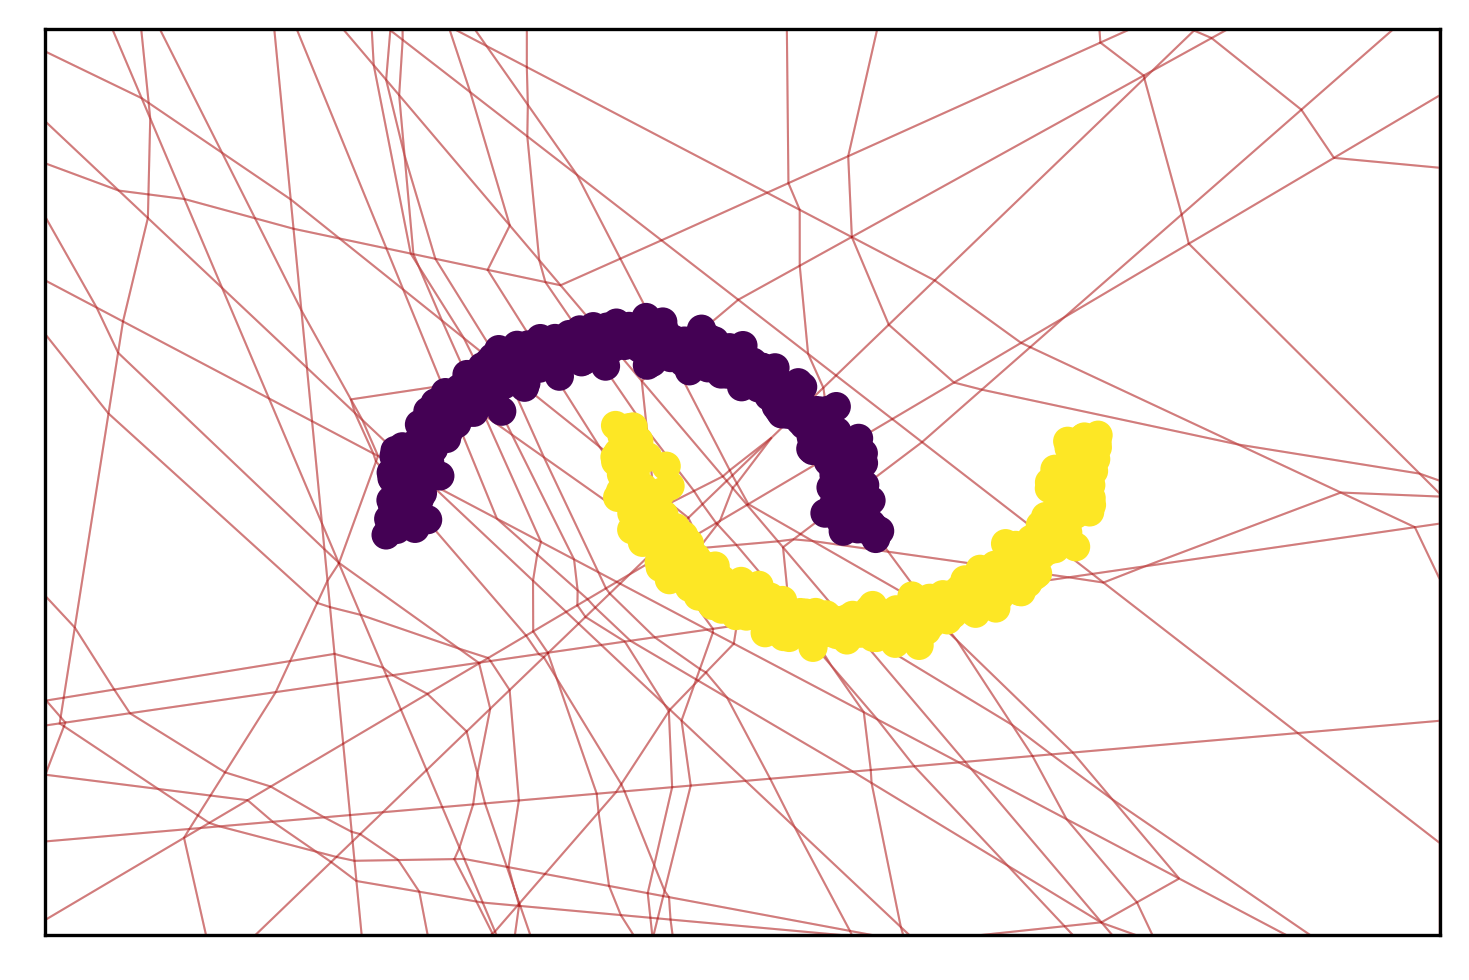

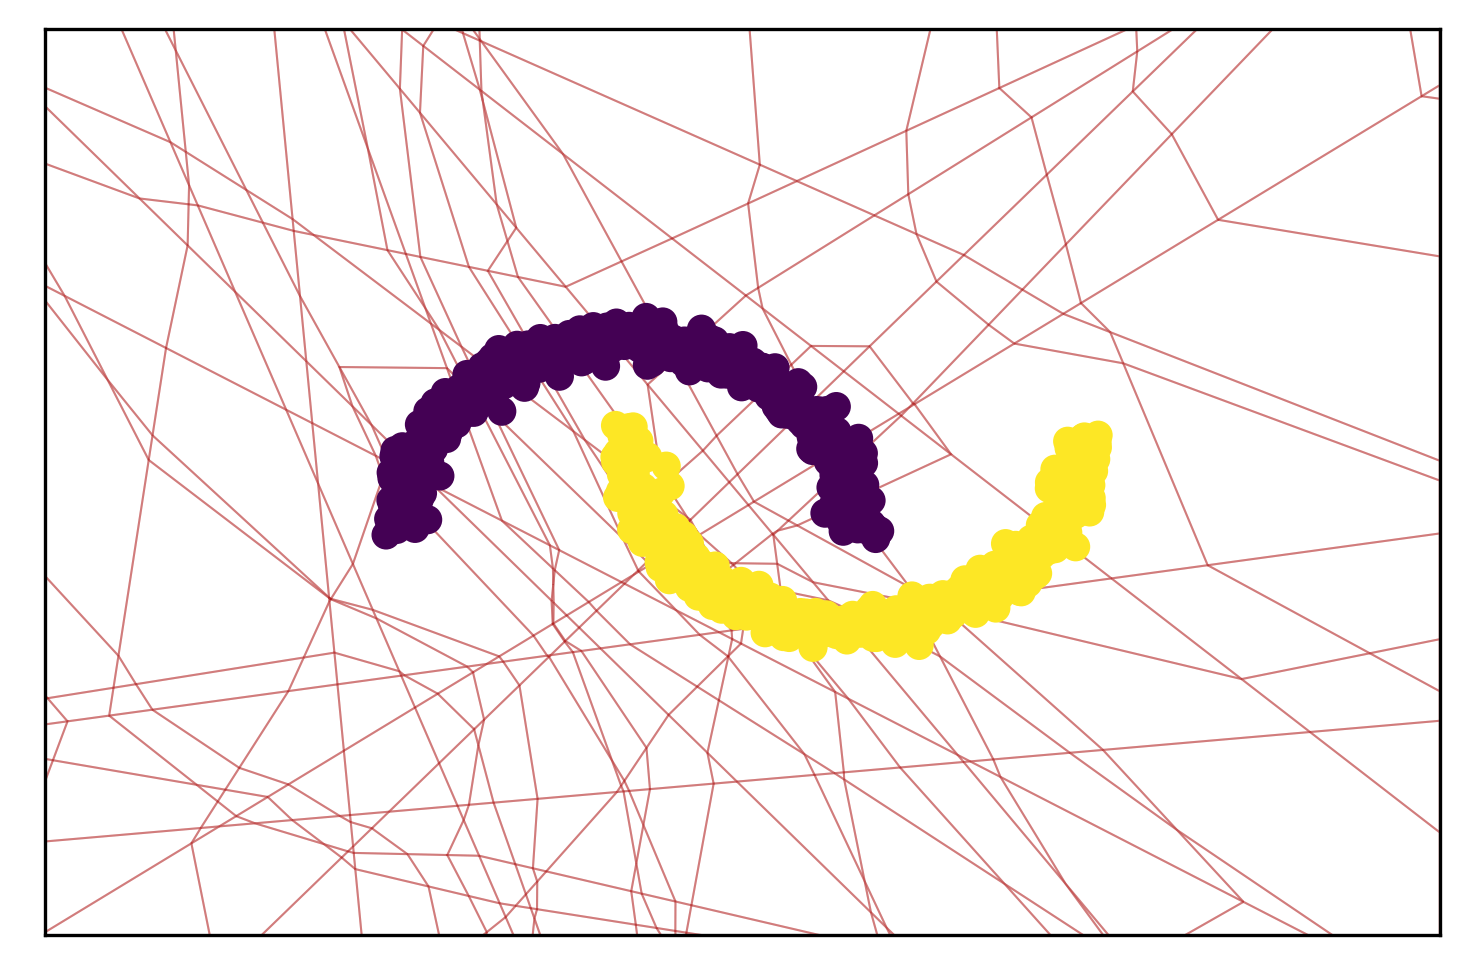

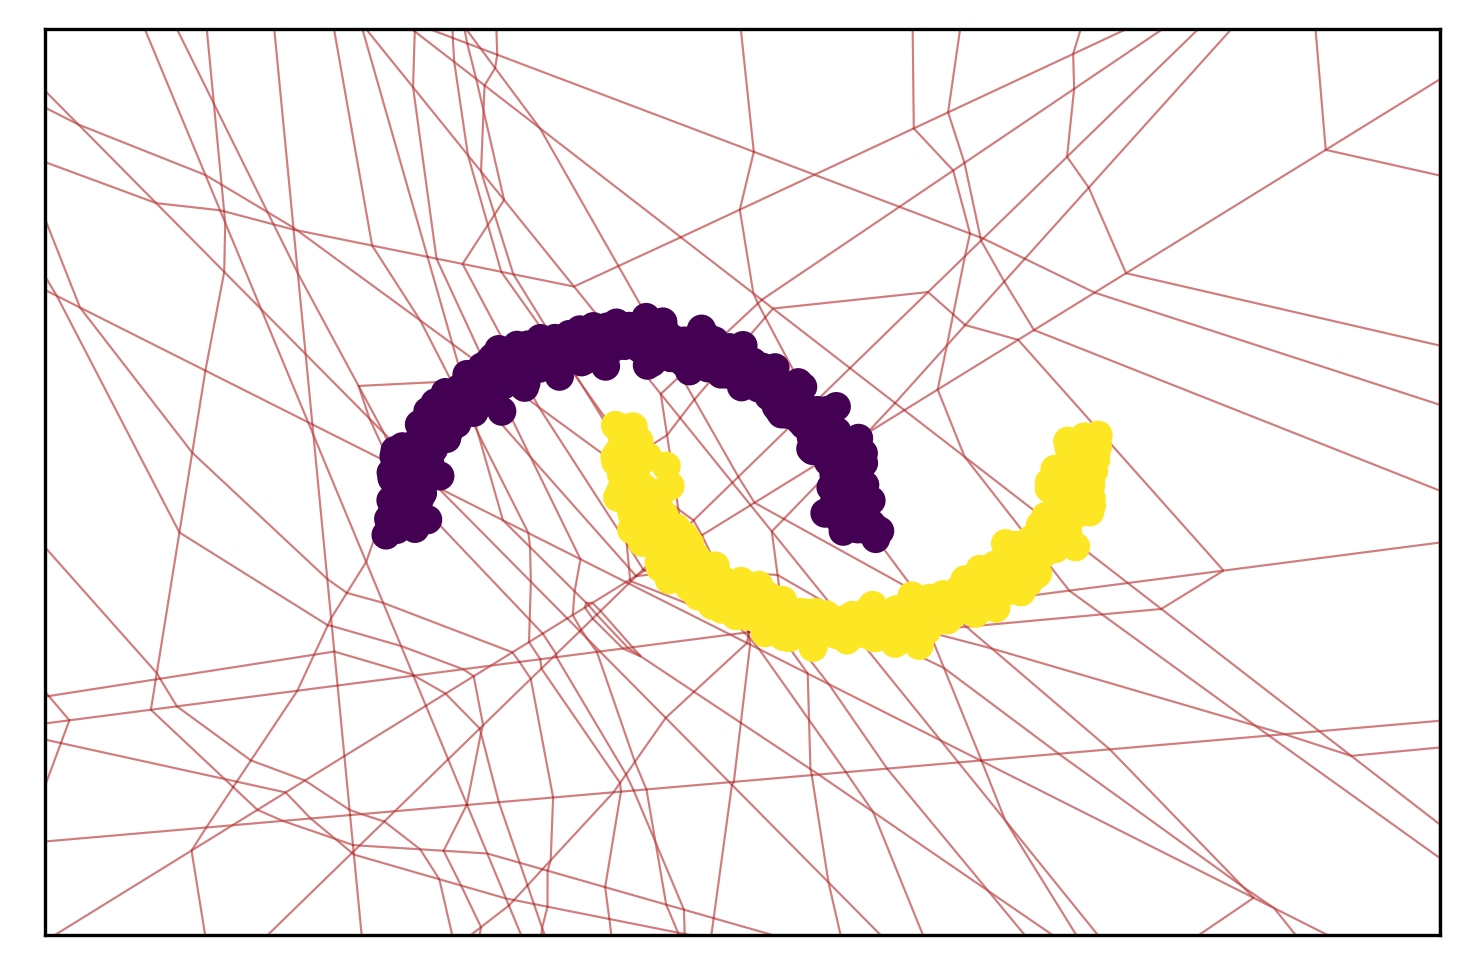

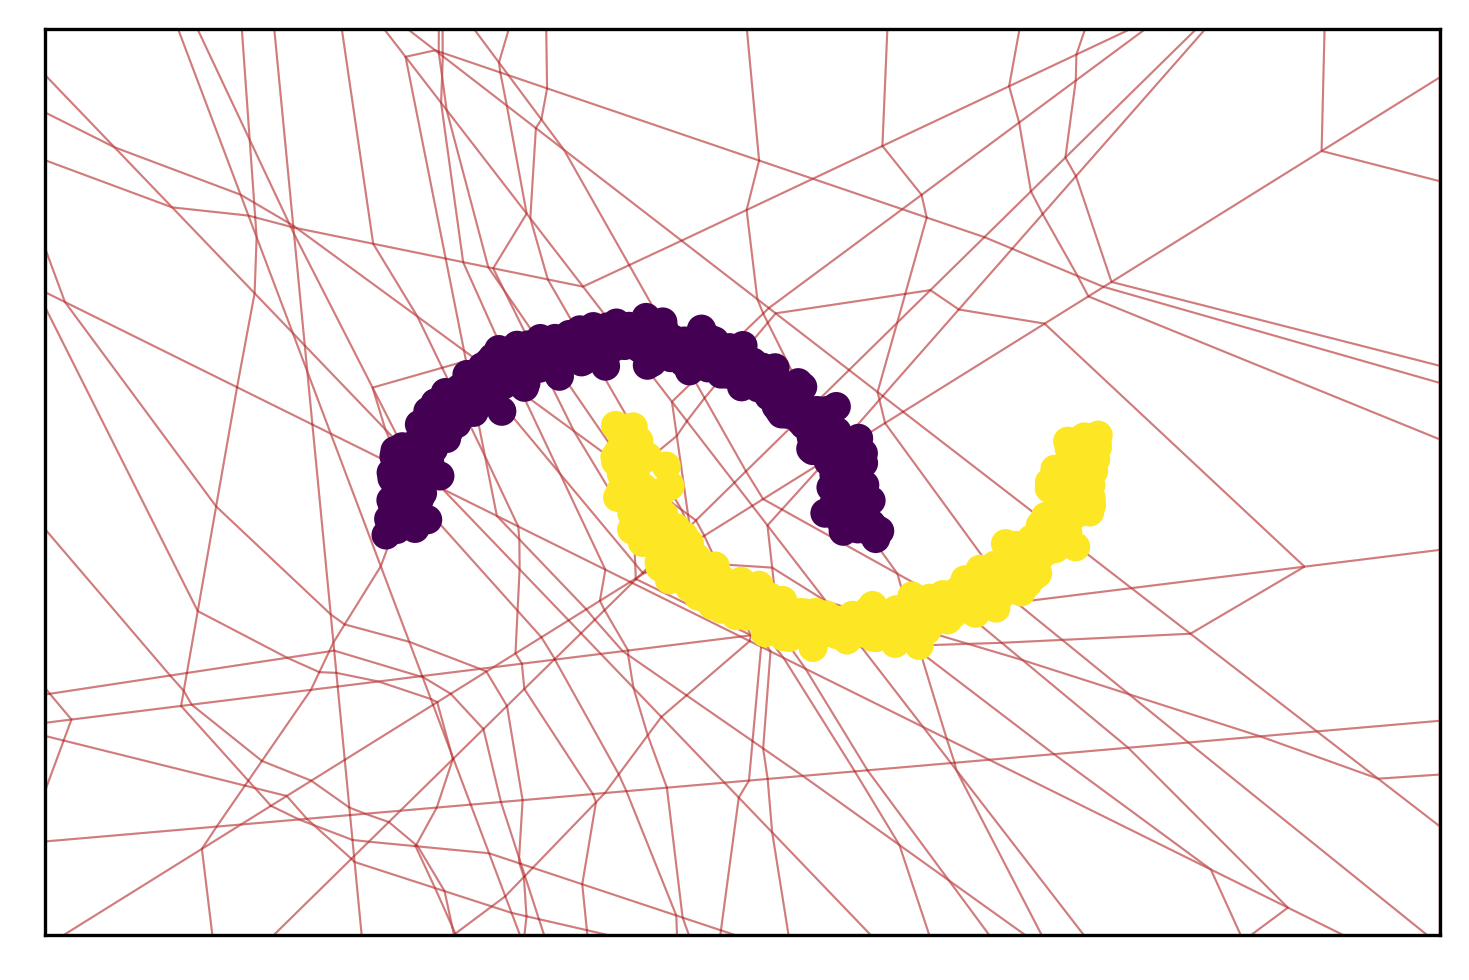

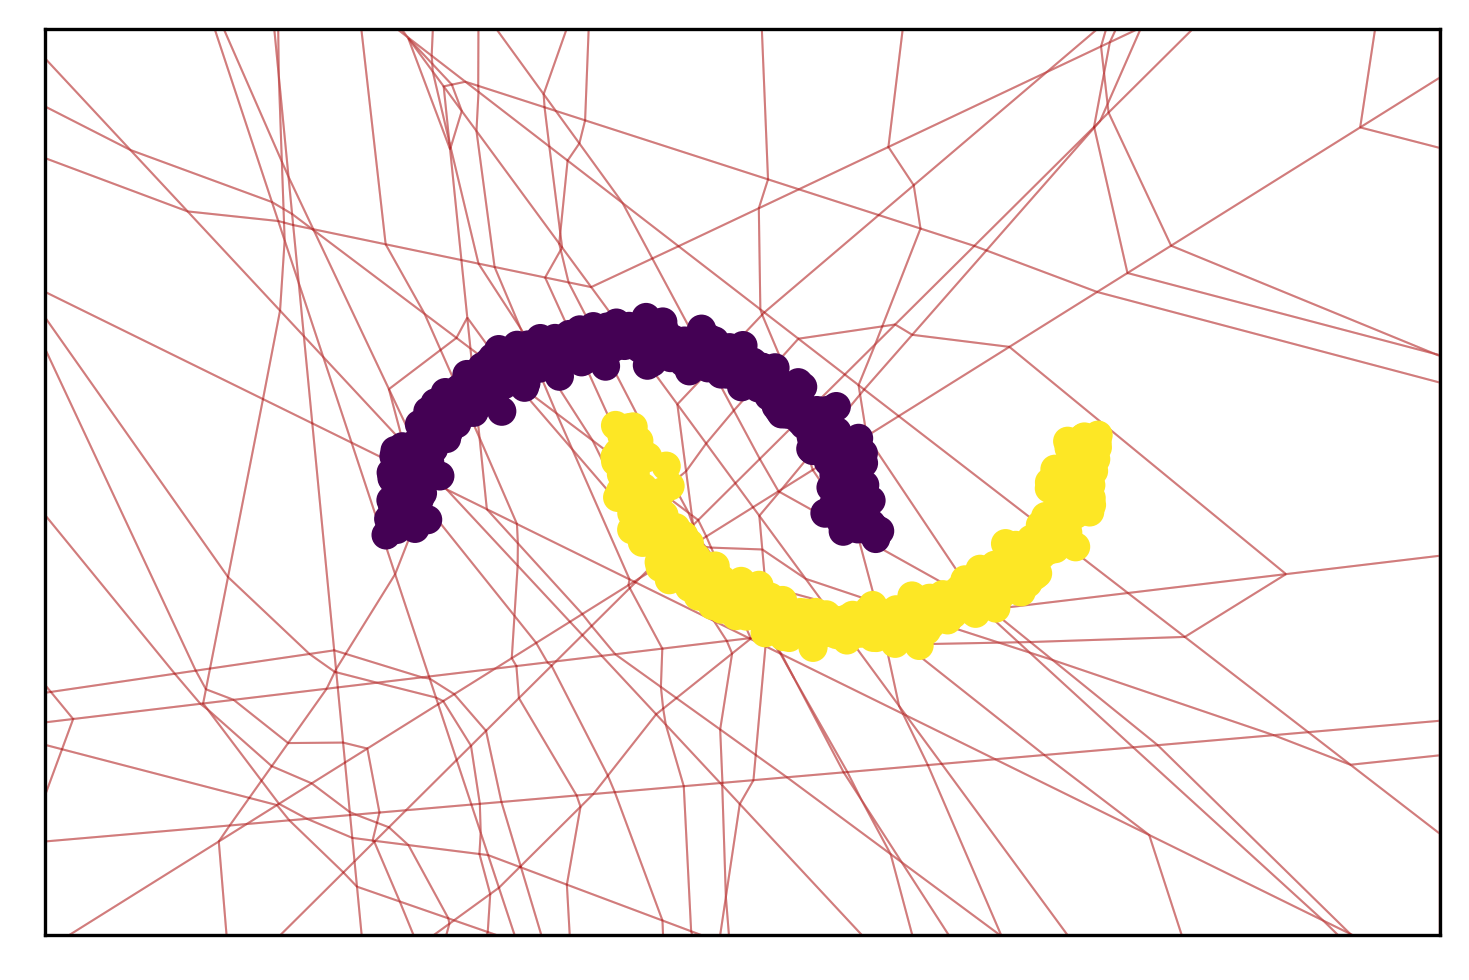

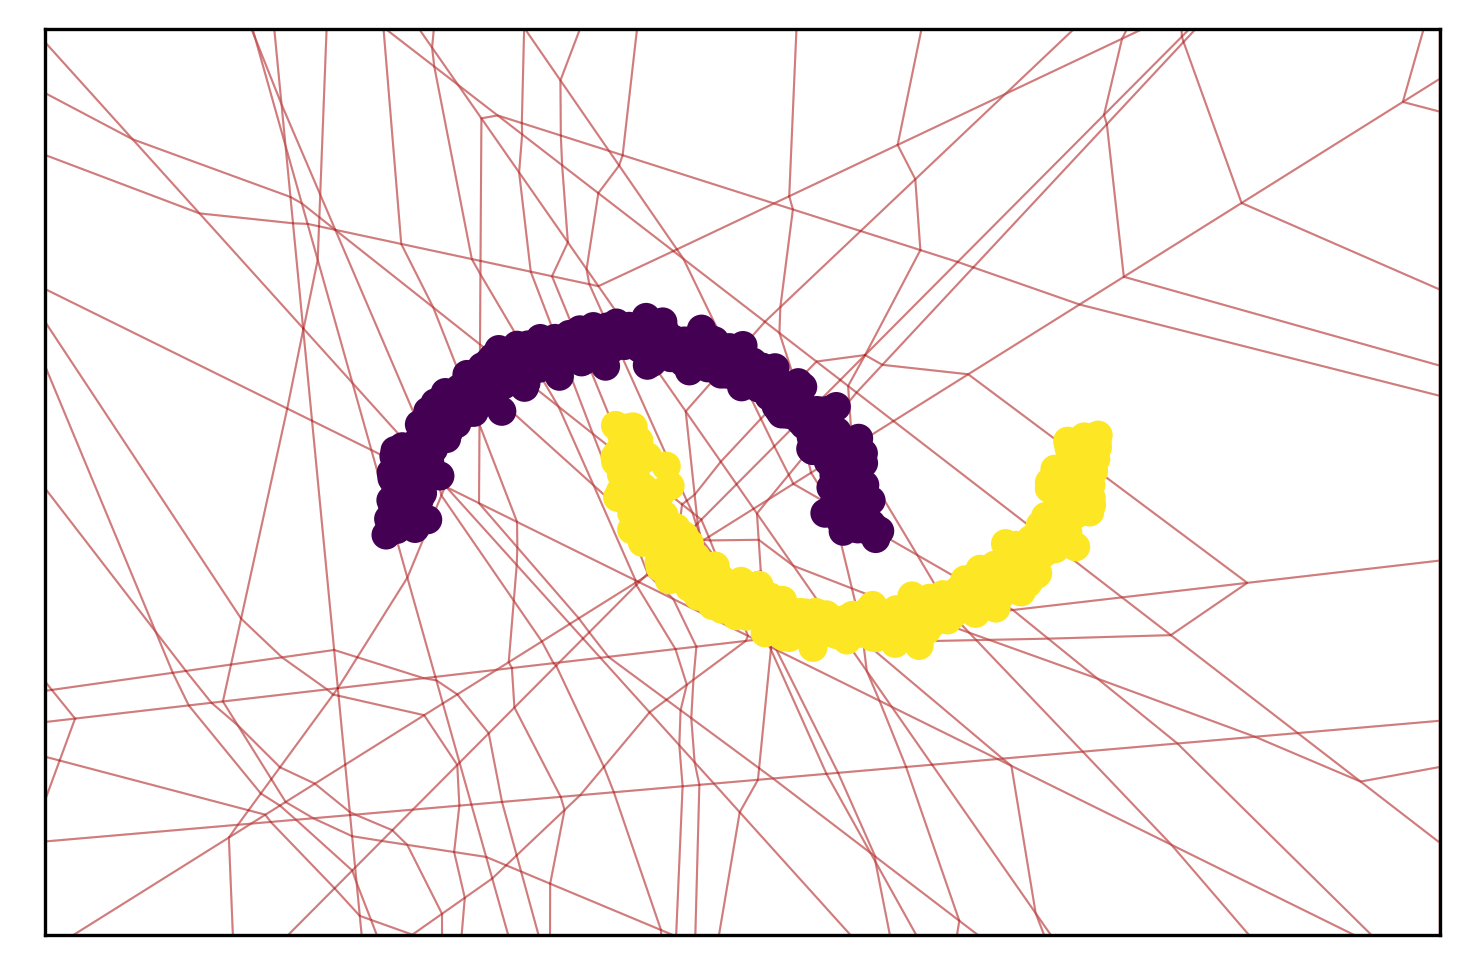

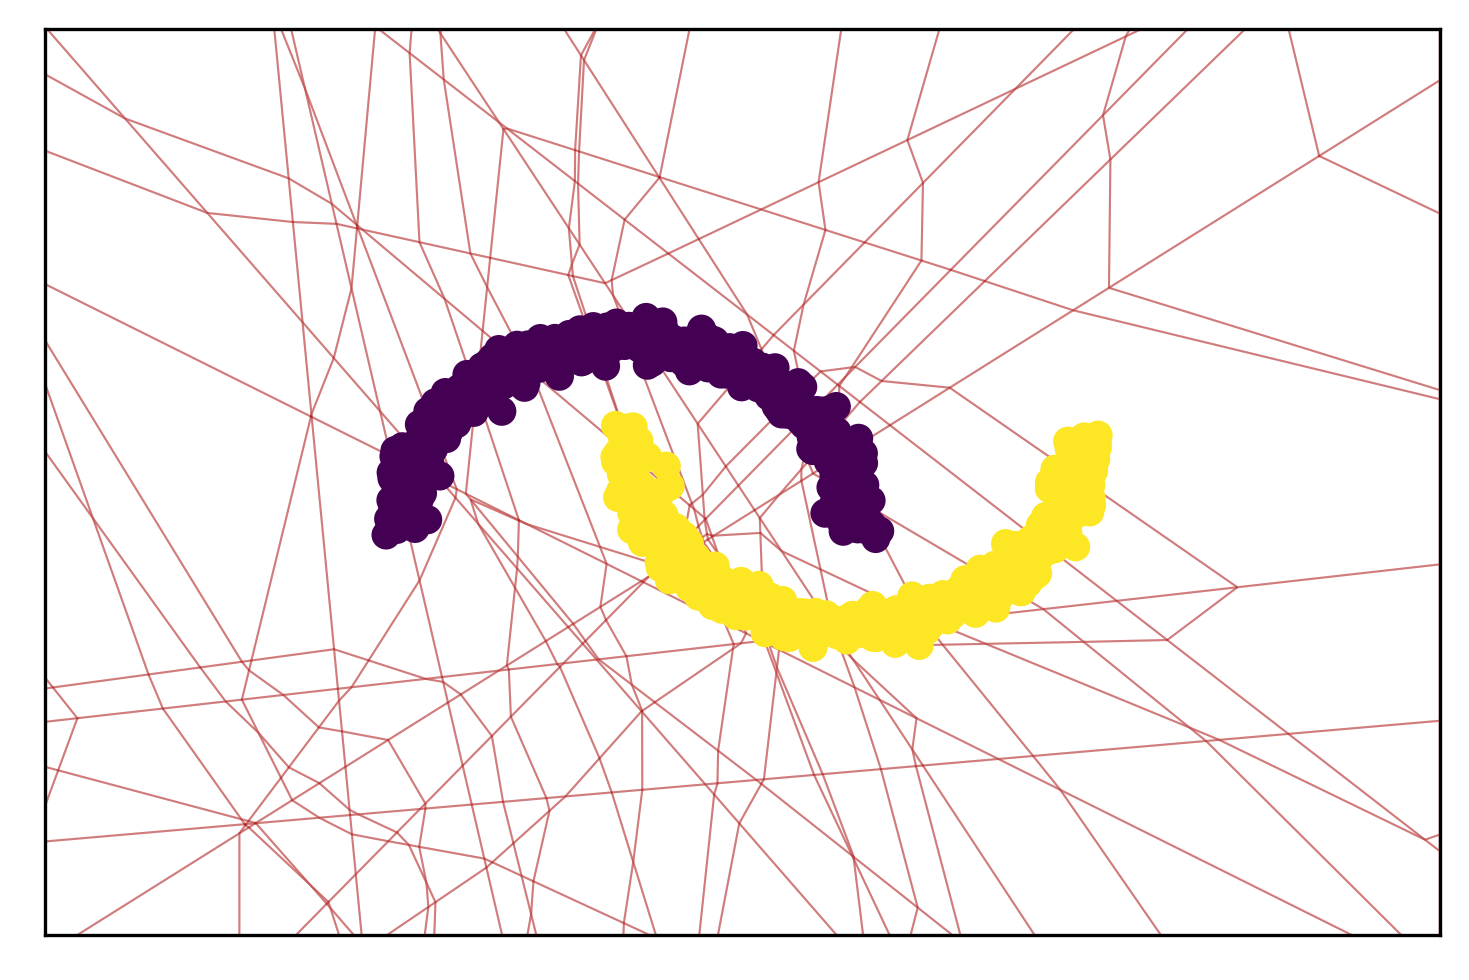

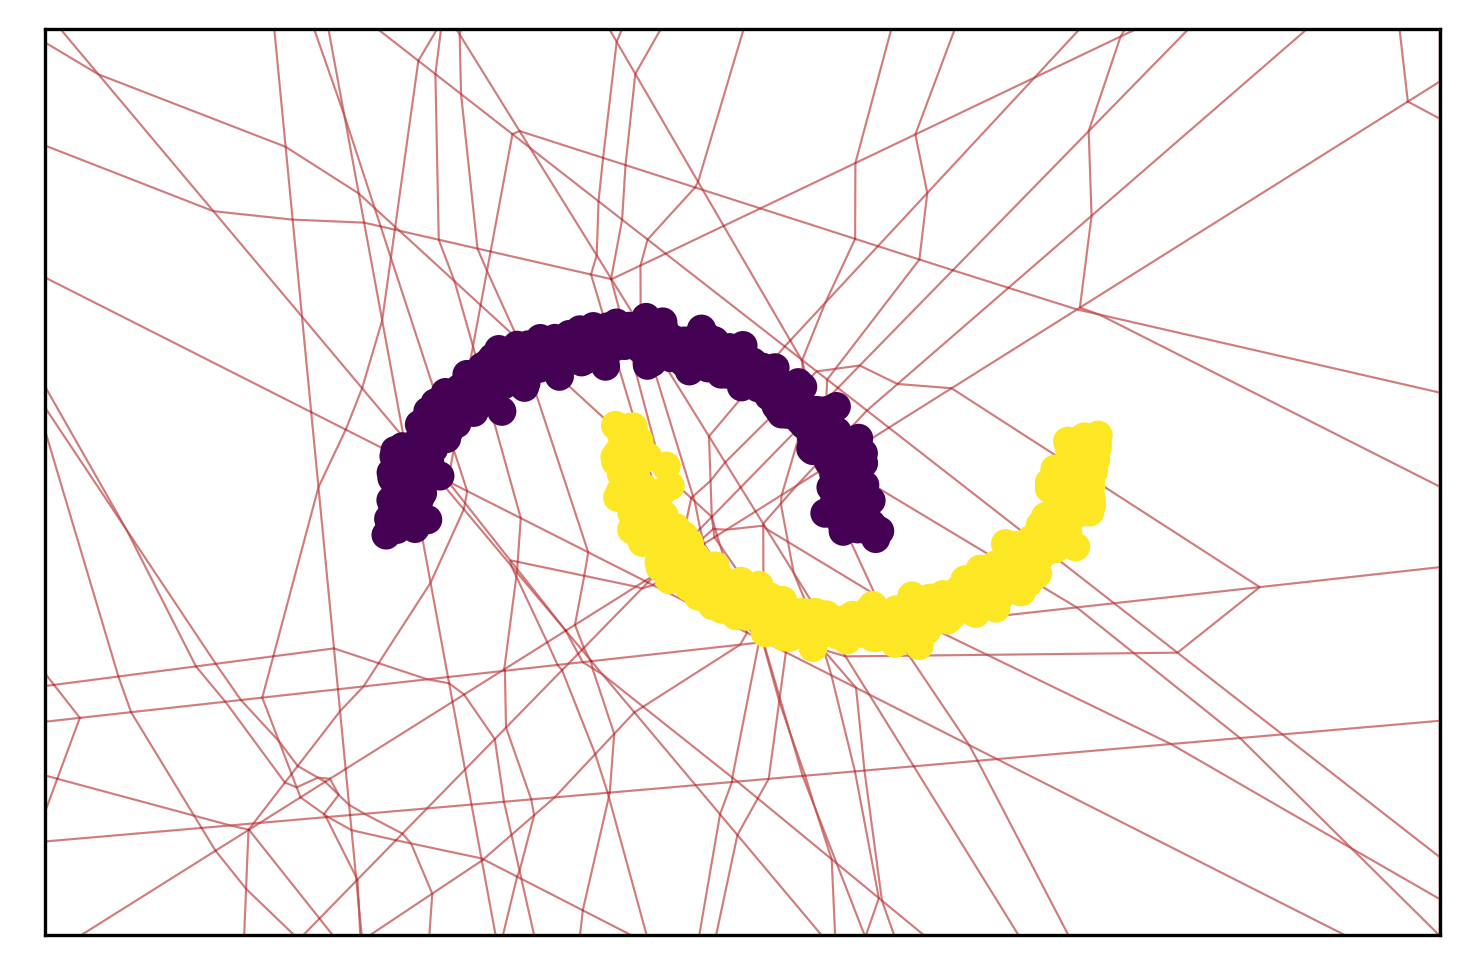

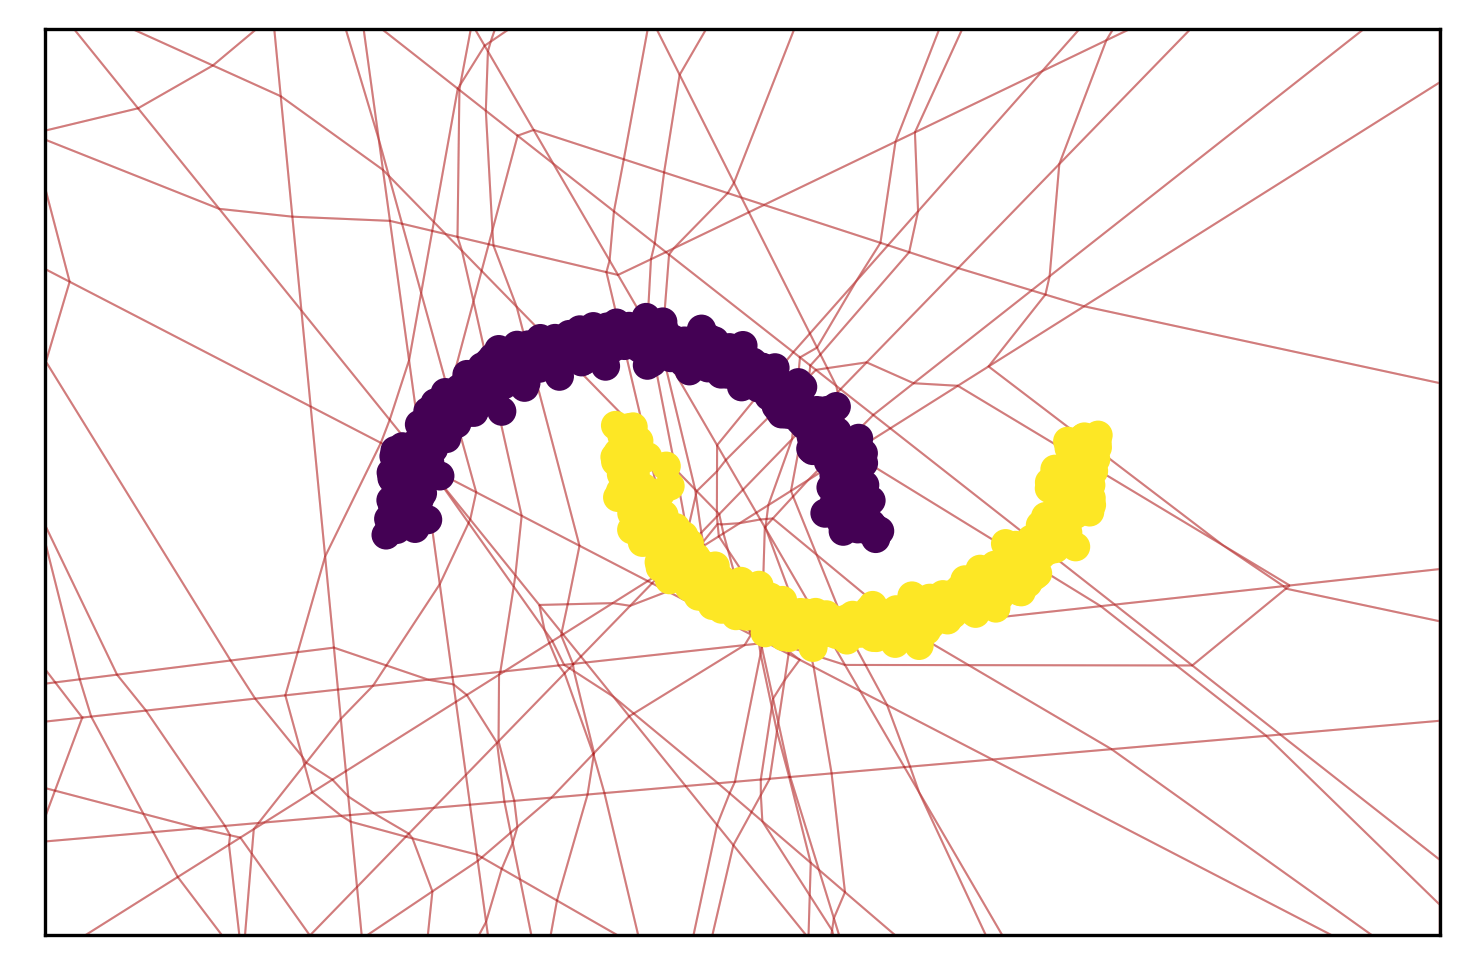

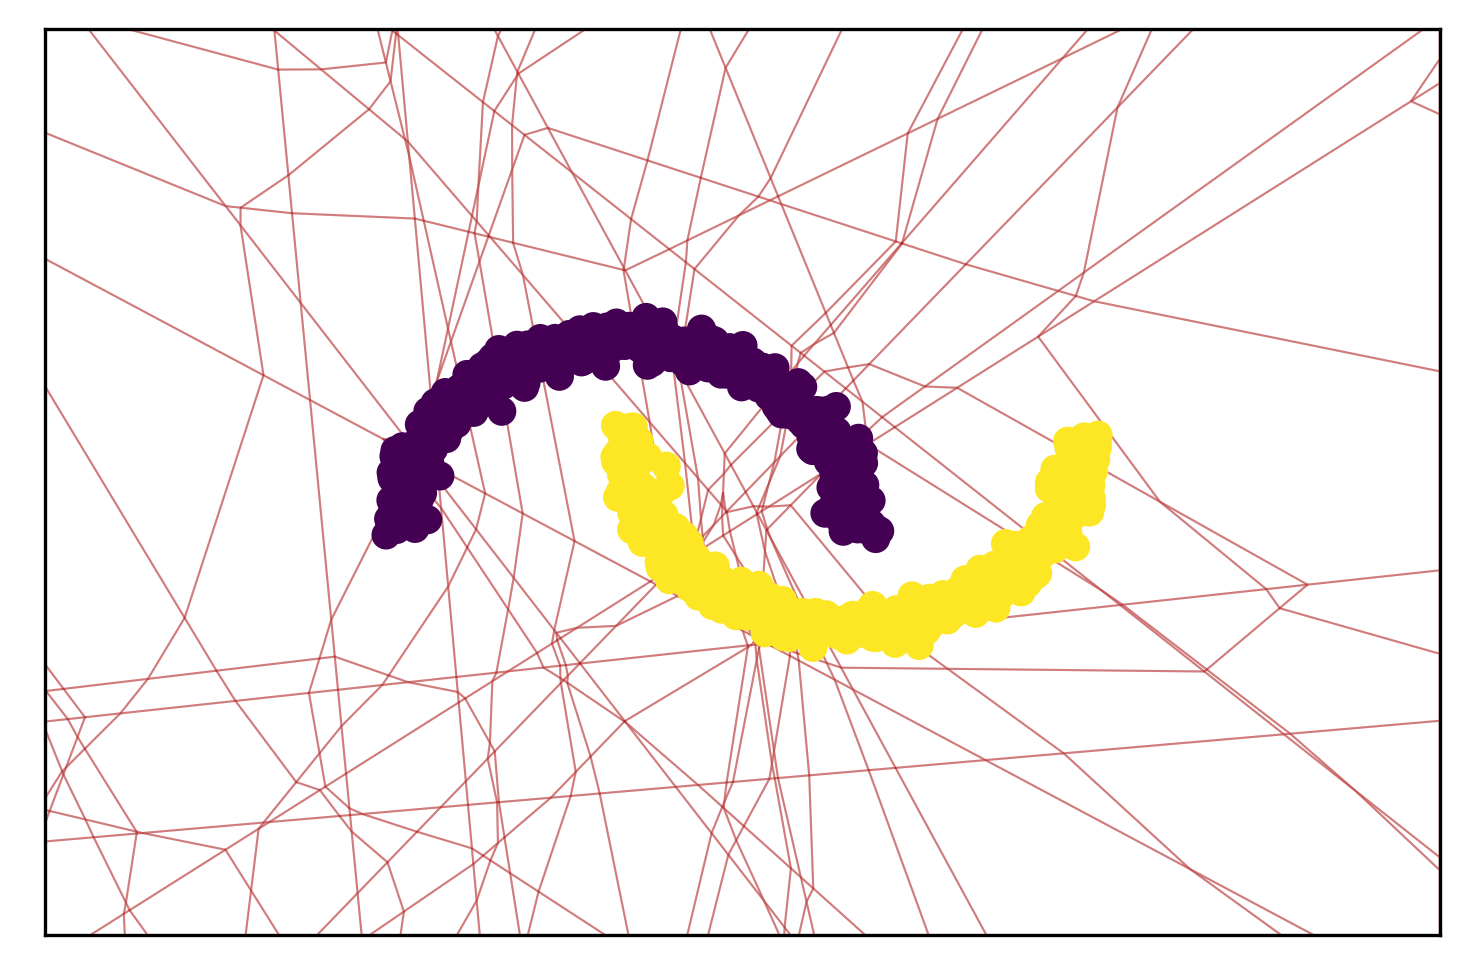

In [ ]:
#@title Train and visualize per iteration

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

epochs = 200
device = 'cuda'
model = model.to(device)

for epoch in range(1, epochs + 1):
    
    ## train step 

    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(dataloader, 1):
        
        # prep data
        data,target = data[:,:-1],data[:,-1:]
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad() # zero accumulated gradients
        output = model(data)

        # calculate loss and perform backprop
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    
    ## visualize partition 
    
    model.cuda()
    model.eval()
    model.type(torch.float64)

    print('Wrapping model with SplineCam...')
    
    NN = splinecam.wrappers.model_wrapper(
        model,
        input_shape=(2,),
        T = T,
        dtype = torch.float64,
        device = 'cuda'
    )

    ## check .forward() and matmul operation equivalence
    # print('Verifying wrapped model...')
    flag =  NN.verify()
    # print('Model.forward and matmul equivalence check', flag)
    assert flag

    ## specify level set for output neuron, for db visualization
    thresh = 0.5
    NN.layers[-1].Ab[0,-1] = NN.layers[-1].Ab[0,-1] + thresh
    
    
    ## get partitions
    out_cyc,endpoints = get_partitions_with_db(domain,T,NN)
    

    plt.rcParams['figure.dpi'] = 300
    fig,ax = plt.subplots()

    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=5)

    minval,_ = torch.vstack(out_cyc).min(0)
    maxval,_ = torch.vstack(out_cyc).max(0)

    splinecam.plot.plot_partition(out_cyc, xlims=[minval[0],maxval[0]],alpha=0.3,
                             edgecolor='#a70000',color_range=[.3,.8],ax=ax,colors=['none'],
                             ylims=[minval[1],maxval[1]], linewidth=.5)


    ax.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
                dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
                c = dataloader.__dict__['dataset'][:,-1].numpy()
               )

    plt.savefig(f'./animation/{epoch}.png',bbox_inches='tight',pad_inches=0)
    
    model.cuda()
    model.train()
    model.type(torch.float32)
    
    # print loss stats
    print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(dataloader)))

del NN, out_cyc, endpoints

In [ ]:
#@title Create Animation

import glob
import imageio
import numpy as np
import tqdm
from cv2 import imread

## list files
files = np.asarray(glob.glob('./animation/*.png'))
idx = np.asarray([int(each.split('/')[-1].split('.')[0]) for each in files])
files = files[idx.argsort()]

## export mp4
fps = 30
with imageio.get_writer('test.mp4', mode='I', fps=fps) as writer:
    for each in tqdm.tqdm(files):
        img = imread(each)[...,::-1] # BRG to RGB
        writer.append_data(img)

100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('test.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)